In [1]:
# (UCL=UPPER CONTROL LIMITS)

### Imports

In [2]:
# libraries importing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import math

# additional modules
import sys
import time
from pathlib import Path

from IPython.display import display, HTML
from IPython.display import clear_output

sys.path.append('../utils')

import numpy as np
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization 
from tensorflow.keras.layers import  Activation, Dropout, TimeDistributed
from tensorflow.keras.layers import LSTM, RepeatVector, Flatten, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
import scipy
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

import multiprocessing

from tqdm import tqdm

In [3]:
import basemodels
import anomalyutils
import utils
import modeltasks

### Random Function

In [4]:
utils.set_random(0)

### Load Data

In [5]:
# benchmark files checking
all_files, all_names = utils.get_files_and_names()
# datasets with anomalies loading
list_of_df, list_of_names = utils.get_anomaly_data_and_names()
# anomaly-free df loading
anomaly_free_df, anomaly_free_name = utils.get_anomaly_free_data_and_names()

In [6]:
def driver_func(mmodel, df, n_cores, name_of_model):
    # mmodel: 
    # modeltasks.ensemble_autoencoder
    # modeltasks.ensemble_conv_ae
    # modeltasks.ensemble_lstm
    # modeltasks.ensemble_lstm_ae
    # modeltasks.ensemble_lstm_vae
    # df: the raw df
    # n_cores: number of cores
    # name_of_model: 
    with multiprocessing.Pool(n_cores) as pool:
        list_of_features = utils.get_bagg_features(11)
        tmp_list_of_feats = [list(feats) for feats in list_of_features] 
        for tmp_feat in tmp_list_of_feats:
            if "anomaly" not in tmp_feat:
                tmp_feat.append("anomaly")
            if "changepoint" not in tmp_feat:
                tmp_feat.append("changepoint")

        df_list_to_run_tmp = [df[feats] for feats in tmp_list_of_feats]
        results = [pool.apply_async(mmodel, (ds, name_of_model, str(ds_ind))) for ds_ind, ds in enumerate(df_list_to_run_tmp)]
        
        voting_prediction = pd.DataFrame(pd.Series(data=0, index=df.index)).rename(columns={0:"initialize"})
        # voting_prediction = pd.DataFrame(pd.Series(data=df.anomaly.astype(int), index=df.index))
        count=0
        for r in results:
            count+=1
            voting_prediction = voting_prediction.join(r.get())

        voting_prediction = voting_prediction.fillna(0)
        voting_prediction = voting_prediction.drop(["initialize"], axis=1)
        for cl in voting_prediction.columns:
            # if "anomaly_by" in cl:
            voting_prediction[cl] = np.where(voting_prediction[cl] == 1 , 1, -1)
        
        voting_prediction[f"anomaly_by_ensemble_{name_of_model}"] = voting_prediction.sum(axis=1)
        voting_prediction[f"anomaly_by_ensemble_{name_of_model}"] = np.where(voting_prediction[f"anomaly_by_ensemble_{name_of_model}"] < 0 , 0, 1)
        final_df = voting_prediction[[f"anomaly_by_ensemble_{name_of_model}"]]
        
    return final_df

### Main Run Loop

In [7]:
%%time
def main(num_of_cores = 10):
    SAVE_FOLDER = "./fastfolder"
    Path(SAVE_FOLDER).mkdir(parents=True, exist_ok=True)
    X_conv_ae_window = 60
    final_aggr_pd = None
    start_of_loop = time.perf_counter()
    times_of_ds = []
    for df_index, df_t in enumerate(zip(list_of_df, list_of_names)):
        df = df_t[0]
        name = df_t[1]

        ensemble_autoencoder_result = driver_func(modeltasks.ensemble_autoencoder, df, num_of_cores, "ensemble_autoencoder")
        ensemble_conv_ae_result = driver_func(modeltasks.ensemble_conv_ae, df, num_of_cores, "ensemble_conv_ae")
        ensemble_lstm_result = driver_func(modeltasks.ensemble_lstm, df, num_of_cores, "ensemble_lstm")
        ensemble_lstm_ae_result = driver_func(modeltasks.ensemble_lstm_ae, df, num_of_cores, "ensemble_lstm_ae")
        ensemble_lstm_vae_result = driver_func(modeltasks.ensemble_lstm_vae, df, num_of_cores, "ensemble_lstm_vae")

        start_ds = time.perf_counter()

        X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
        
        # scaler init and fitting
        StSc = StandardScaler()
        StSc.fit(X_train)

        X_ae = StSc.transform(X_train)
        X_conv_ae = utils.create_sequences(StSc.transform(X_train), X_conv_ae_window)
        X_lstm, y_lstm = utils.split_sequences(StSc.transform(X_train), 5)
        X_lstm_ae = utils.create_sequences(StSc.transform(X_train), 10)
        X_lstm_vae = utils.create_sequences(StSc.transform(X_train), 5)

        # model defining and fitting
        
        autoencoder_model = basemodels.autoencoder(X_ae)
        conv_ae_model = basemodels.conv_ae(X_conv_ae)
        lstm_model = basemodels.lstm(X_lstm, y_lstm)
        lstm_ae_model = basemodels.lstm_ae(X_lstm_ae)
        lstm_vae_model = basemodels.lstm_vae(X_lstm_vae)

        lstm_model.load_weights("lstm.h5")
        
        predictions_ae = anomalyutils.get_ae_predicts(autoencoder_model, X_ae)
        predictions_conv_ae = anomalyutils.get_conv_ae_predicts(conv_ae_model, X_conv_ae)
        predictions_lstm = anomalyutils.get_lstm_predicts(lstm_model, X_lstm)
        predictions_lstm_ae = anomalyutils.get_lstm_ae_predicts(lstm_ae_model, X_lstm_ae)
        predictions_lstm_vae = anomalyutils.get_lstm_vae_predicts(lstm_vae_model, X_lstm_vae)

        residuals_autoencoder = anomalyutils.get_ae_residuals(X_ae, predictions_ae)
        residuals_conv_ae = anomalyutils.get_conv_ae_residuals(X_conv_ae, predictions_conv_ae)
        residuals_lstm = anomalyutils.get_lstm_residuals(y_lstm, predictions_lstm)
        residuals_lstm_ae = anomalyutils.get_lstm_ae_residuals(X_lstm_ae, predictions_lstm_ae)
        residuals_lstm_vae = anomalyutils.get_lstm_vae_residuals(X_lstm_vae, predictions_lstm_vae)

        UCL_autoencoder = residuals_autoencoder.quantile(0.99)
        UCL_conv_ae = residuals_conv_ae.quantile(0.999)
        UCL_lstm = residuals_lstm.quantile(0.99)
        UCL_lstm_ae = residuals_lstm_ae.quantile(0.99)
        UCL_lstm_vae = residuals_lstm_vae.quantile(0.999)

        X_all = df.drop(['anomaly','changepoint'], axis=1)
        X_ae = StSc.transform(X_all)
        X_conv_ae = utils.create_sequences(StSc.transform(X_all), X_conv_ae_window)
        X_lstm, y_lstm = utils.split_sequences(StSc.transform(X_all), 5)
        X_lstm_ae = utils.create_sequences(StSc.transform(X_all), 10)
        X_lstm_vae = utils.create_sequences(StSc.transform(X_all), 5)
        
        predictions_ae = anomalyutils.get_ae_predicts(autoencoder_model, X_ae)
        predictions_conv_ae = anomalyutils.get_conv_ae_predicts(conv_ae_model, X_conv_ae)
        predictions_lstm = anomalyutils.get_lstm_predicts(lstm_model, X_lstm)
        predictions_lstm_ae = anomalyutils.get_lstm_ae_predicts(lstm_ae_model, X_lstm_ae)
        predictions_lstm_vae = anomalyutils.get_lstm_vae_predicts(lstm_vae_model, X_lstm_vae)

        residuals_autoencoder = anomalyutils.get_ae_residuals(X_ae, predictions_ae)
        residuals_conv_ae = anomalyutils.get_conv_ae_residuals(X_conv_ae, predictions_conv_ae)
        residuals_lstm = anomalyutils.get_lstm_residuals(y_lstm, predictions_lstm)
        residuals_lstm_ae = anomalyutils.get_lstm_ae_residuals(X_lstm_ae, predictions_lstm_ae)
        residuals_lstm_vae = anomalyutils.get_lstm_vae_residuals(X_lstm_vae, predictions_lstm_vae)

        prediction_labels_autoencoder = pd.DataFrame(pd.Series((residuals_autoencoder > 3/2*UCL_autoencoder).astype(int).values, index=df.index).fillna(0))
        prediction_labels_conv_ae = pd.DataFrame(utils.get_anomalies_labels_from_continuous_windows(X_conv_ae, residuals_conv_ae, X_conv_ae_window, UCL_conv_ae, df.index))
        prediction_labels_lstm = pd.DataFrame(pd.Series((residuals_lstm>3/2*UCL_lstm).astype(int).values, index=df[5:].index).fillna(0))
        prediction_labels_lstm_ae = pd.DataFrame(utils.get_anomalies_labels_from_continuous_windows(X_lstm_ae, residuals_lstm_ae, 10, UCL_lstm_ae, df.index))
        prediction_labels_lstm_vae = pd.DataFrame(utils.get_anomalies_labels_from_continuous_windows(X_lstm_vae, residuals_lstm_vae, 5, UCL_lstm_vae, df.index)) 

        prediction_autoencoder_logreg = pd.DataFrame(pd.Series(residuals_autoencoder.values, index=df.index).fillna(0)).rename(columns={0:"anomaly_by_autoencoder"})
        prediction_conv_ae_logreg = pd.DataFrame(utils.get_scores_from_residuals(X_conv_ae, residuals_conv_ae, X_conv_ae_window, df.index)).rename(columns={0:"anomaly_by_conv_ae"})
        prediction_lstm_logreg = pd.DataFrame(pd.Series(residuals_lstm.values, index=df[5:].index).fillna(0)).rename(columns={0:"anomaly_by_lstm"})
        prediction_lstm_ae_logreg = pd.DataFrame(utils.get_scores_from_residuals(X_lstm_ae, residuals_lstm_ae, 10, df.index)).rename(columns={0:"anomaly_by_lstm_ae"})
        prediction_lstm_vae_logreg = pd.DataFrame(utils.get_scores_from_residuals(X_lstm_vae, residuals_lstm_vae, 5, df.index)) .rename(columns={0:"anomaly_by_lstm_vae"})
        
        prediction_autoencoder_logreg = prediction_autoencoder_logreg[400:600]
        prediction_conv_ae_logreg = prediction_conv_ae_logreg[400:600]
        prediction_lstm_logreg = prediction_lstm_logreg[400:600]
        prediction_lstm_ae_logreg = prediction_lstm_ae_logreg[400:600]
        prediction_lstm_vae_logreg = prediction_lstm_vae_logreg[400:600]

        data_logreg = pd.DataFrame(pd.Series(data=df[400:600]["anomaly"].astype(int), index=df[400:600].index))
        data_logreg = data_logreg.join(prediction_autoencoder_logreg)
        data_logreg = data_logreg.join(prediction_conv_ae_logreg)
        data_logreg = data_logreg.join(prediction_lstm_logreg)
        data_logreg = data_logreg.join(prediction_lstm_ae_logreg)
        data_logreg = data_logreg.join(prediction_lstm_vae_logreg)
        data_logreg = data_logreg.fillna(0)

        try:
            cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", "anomaly_by_lstm_vae"]
            X_logreg = data_logreg[cols]
            Y_logreg = data_logreg["anomaly"]
            logreg = LogisticRegression()
            
            logreg.fit(X_logreg, Y_logreg)
        except Exception as e:
            if "one class" in e.__str__():
                print(f"================= ERROR INDEX DS: {df_index} =================")
                print(e)
                print(df_index)
                print(f"================= END ERROR INDEX DS: {df_index} =================")
                continue
        # logreg.coef_
        # logreg.intercept_

        prediction_autoencoder_logreg_all = pd.DataFrame(pd.Series(residuals_autoencoder.values, index=df.index).fillna(0)).rename(columns={0:"anomaly_by_autoencoder"})
        prediction_conv_ae_logreg_all = pd.DataFrame(utils.get_scores_from_residuals(X_conv_ae, residuals_conv_ae, X_conv_ae_window, df.index)).rename(columns={0:"anomaly_by_conv_ae"})
        prediction_lstm_logreg_all = pd.DataFrame(pd.Series(residuals_lstm.values, index=df[5:].index).fillna(0)).rename(columns={0:"anomaly_by_lstm"})
        prediction_lstm_ae_logreg_all = pd.DataFrame(utils.get_scores_from_residuals(X_lstm_ae, residuals_lstm_ae, 10, df.index)).rename(columns={0:"anomaly_by_lstm_ae"})
        prediction_lstm_vae_logreg_all = pd.DataFrame(utils.get_scores_from_residuals(X_lstm_vae, residuals_lstm_vae, 5, df.index)) .rename(columns={0:"anomaly_by_lstm_vae"})
        
        data_logreg = pd.DataFrame(pd.Series(data=df["anomaly"].astype(int), index=df.index))
        data_logreg = data_logreg.join(prediction_autoencoder_logreg_all)
        data_logreg = data_logreg.join(prediction_conv_ae_logreg_all)
        data_logreg = data_logreg.join(prediction_lstm_logreg_all)
        data_logreg = data_logreg.join(prediction_lstm_ae_logreg_all)
        data_logreg = data_logreg.join(prediction_lstm_vae_logreg_all)
        data_logreg = data_logreg.fillna(0)

        cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", "anomaly_by_lstm_vae"]
        X_logreg_all = data_logreg[cols]
        logreg_prediction = logreg.predict(X_logreg_all)

        prediction_labels_logreg = pd.DataFrame(logreg_prediction)
        prediction_labels_logreg = pd.DataFrame(pd.Series(logreg_prediction, index=df.index).fillna(0)).rename(columns={0:"anomaly_by_logistic_regression"})

        prediction_labels_autoencoder = prediction_labels_autoencoder.rename(columns={0:"anomaly_by_autoencoder"})
        prediction_labels_conv_ae = prediction_labels_conv_ae.rename(columns={0:"anomaly_by_conv_ae"})
        prediction_labels_lstm = prediction_labels_lstm.rename(columns={0:"anomaly_by_lstm"})
        prediction_labels_lstm_ae = prediction_labels_lstm_ae.rename(columns={0:"anomaly_by_lstm_ae"})
        prediction_labels_lstm_vae = prediction_labels_lstm_vae.rename(columns={0:"anomaly_by_lstm_vae"})
        
        voting_prediction = pd.DataFrame(pd.Series(data=df.anomaly.astype(int), index=df.index))
        voting_prediction = voting_prediction.join(prediction_labels_autoencoder)
        voting_prediction = voting_prediction.join(prediction_labels_conv_ae)
        voting_prediction = voting_prediction.join(prediction_labels_lstm)
        voting_prediction = voting_prediction.join(prediction_labels_lstm_ae)
        voting_prediction = voting_prediction.join(prediction_labels_lstm_vae)
        voting_prediction = voting_prediction.join(prediction_labels_logreg)
        voting_prediction = voting_prediction.join(ensemble_autoencoder_result)
        voting_prediction = voting_prediction.join(ensemble_conv_ae_result)
        voting_prediction = voting_prediction.join(ensemble_lstm_result)
        voting_prediction = voting_prediction.join(ensemble_lstm_ae_result)
        voting_prediction = voting_prediction.join(ensemble_lstm_vae_result)
        voting_prediction = voting_prediction.fillna(0)
        voting_prediction['anomaly_by_autoencoder'] = np.where(voting_prediction['anomaly_by_autoencoder'] == 1 , 1, -1)
        voting_prediction['anomaly_by_conv_ae'] = np.where(voting_prediction['anomaly_by_conv_ae'] == 1 , 1, -1)
        voting_prediction['anomaly_by_lstm'] = np.where(voting_prediction['anomaly_by_lstm'] == 1 , 1, -1)
        voting_prediction['anomaly_by_lstm_ae'] = np.where(voting_prediction['anomaly_by_lstm_ae'] == 1 , 1, -1)
        voting_prediction['anomaly_by_lstm_vae'] = np.where(voting_prediction['anomaly_by_lstm_vae'] == 1 , 1, -1)
        
        voting_prediction["anomaly_by_voting"] = voting_prediction['anomaly_by_autoencoder']\
            + voting_prediction['anomaly_by_conv_ae'] + voting_prediction['anomaly_by_lstm'] \
                + voting_prediction['anomaly_by_lstm_ae'] + voting_prediction['anomaly_by_lstm_vae']

        voting_prediction['anomaly_by_autoencoder'] = np.where(voting_prediction['anomaly_by_autoencoder'] == 1 , 1, 0)
        voting_prediction['anomaly_by_conv_ae'] = np.where(voting_prediction['anomaly_by_conv_ae'] == 1 , 1, 0)
        voting_prediction['anomaly_by_lstm'] = np.where(voting_prediction['anomaly_by_lstm'] == 1 , 1, 0)
        voting_prediction['anomaly_by_lstm_ae'] = np.where(voting_prediction['anomaly_by_lstm_ae'] == 1 , 1, 0)
        voting_prediction['anomaly_by_lstm_vae'] = np.where(voting_prediction['anomaly_by_lstm_vae'] == 1 , 1, 0)
        voting_prediction["anomaly_by_voting"] = np.where(voting_prediction['anomaly_by_voting'] < 0 , 0, 1)
        voting_prediction["anomaly_by_logistic_regression"] = np.where(voting_prediction['anomaly_by_logistic_regression'] == 0 , 0, 1)

        cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", 
                "anomaly_by_lstm_vae", "anomaly_by_voting", "anomaly_by_logistic_regression",
                "anomaly_by_ensemble_ensemble_autoencoder", "anomaly_by_ensemble_ensemble_conv_ae", 
                "anomaly_by_ensemble_ensemble_lstm", "anomaly_by_ensemble_ensemble_lstm_ae", 
                "anomaly_by_ensemble_ensemble_lstm_vae"]

        
        save_path =f"{SAVE_FOLDER}/{df_index}.png"
        utils.plot_confusion_matrix_all(voting_prediction, "anomaly" , *cols, save_image=save_path)
        
        final_aggr_pd = pd.concat([final_aggr_pd, voting_prediction], ignore_index=True)

        end_ds = time.perf_counter()

        print(end_ds-start_ds)

        clear_output(wait=True)
        
        times_of_ds.append(end_ds-start_ds)
    end_of_loop = time.perf_counter()

    for i in range(0,len(times_of_ds)):
        print(f"{i}){times_of_ds[i]}")
    print(end_of_loop-start_of_loop)

    clear_output(wait=True)
    
    return final_aggr_pd

Wall time: 0 ns


### Summary

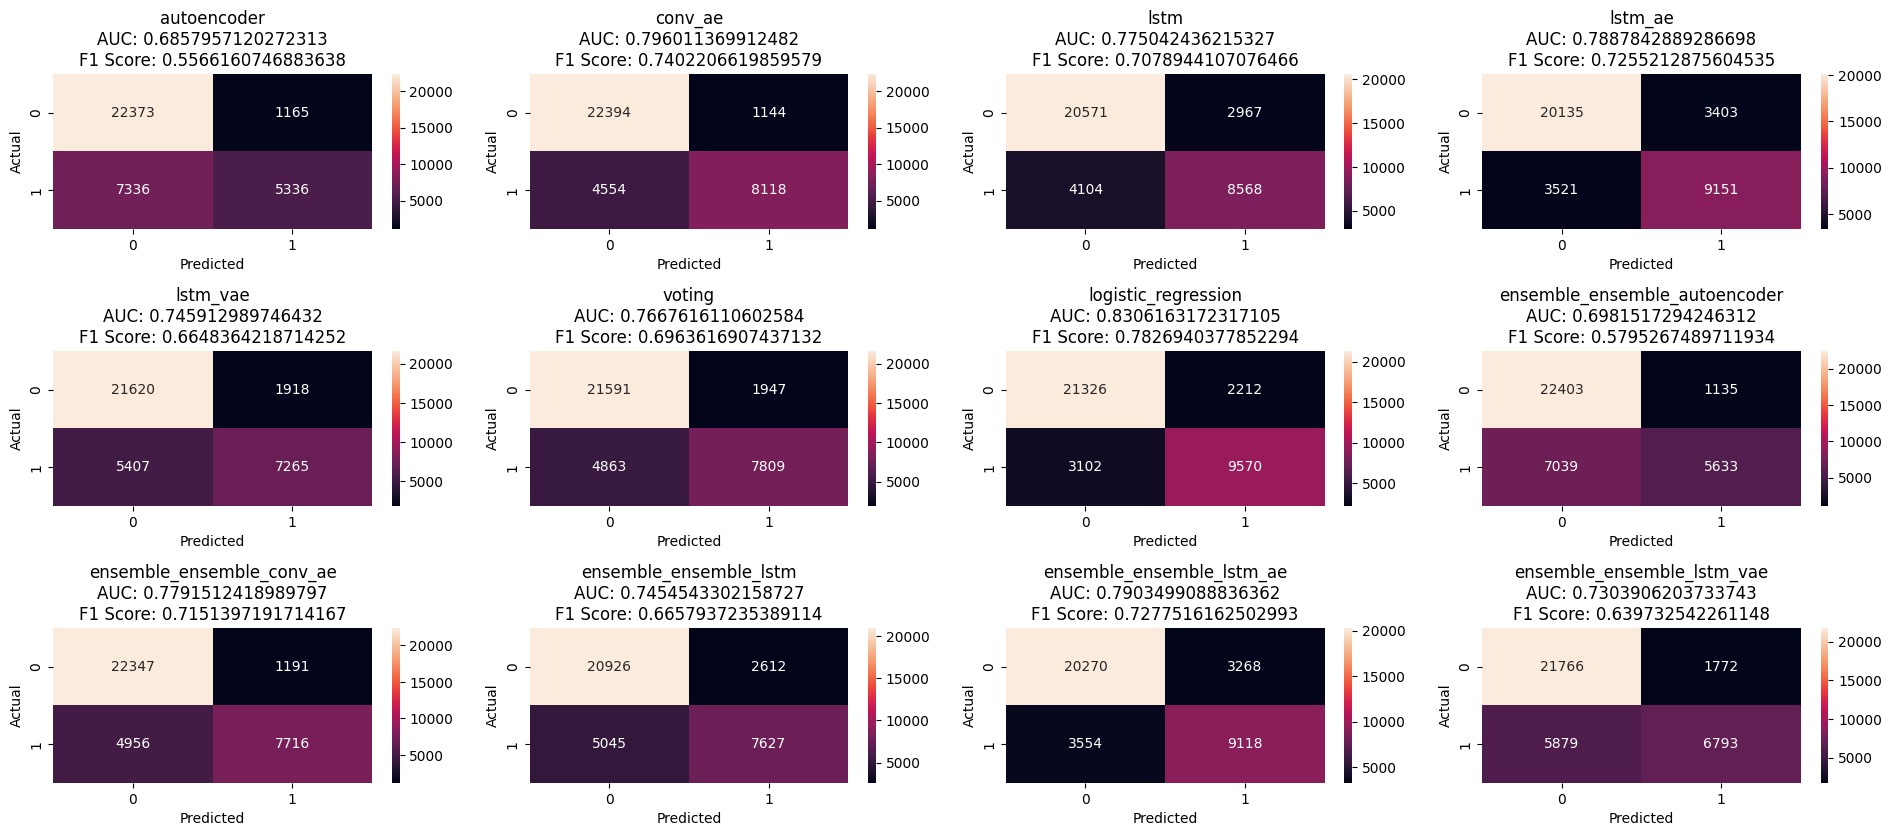

Wall time: 2h 48min 34s


In [8]:
%%time
if __name__ == '__main__':
    final_aggr_pd = main()
    SAVE_FOLDER = "./fastfolder"
    save_path =f"{SAVE_FOLDER}/ALL_together.png"
    cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", 
                    "anomaly_by_lstm_vae", "anomaly_by_voting", "anomaly_by_logistic_regression",
                    "anomaly_by_ensemble_ensemble_autoencoder", "anomaly_by_ensemble_ensemble_conv_ae", 
                    "anomaly_by_ensemble_ensemble_lstm", "anomaly_by_ensemble_ensemble_lstm_ae", 
                    "anomaly_by_ensemble_ensemble_lstm_vae"]
    utils.plot_confusion_matrix_all(final_aggr_pd, "anomaly", *cols, save_image=save_path)

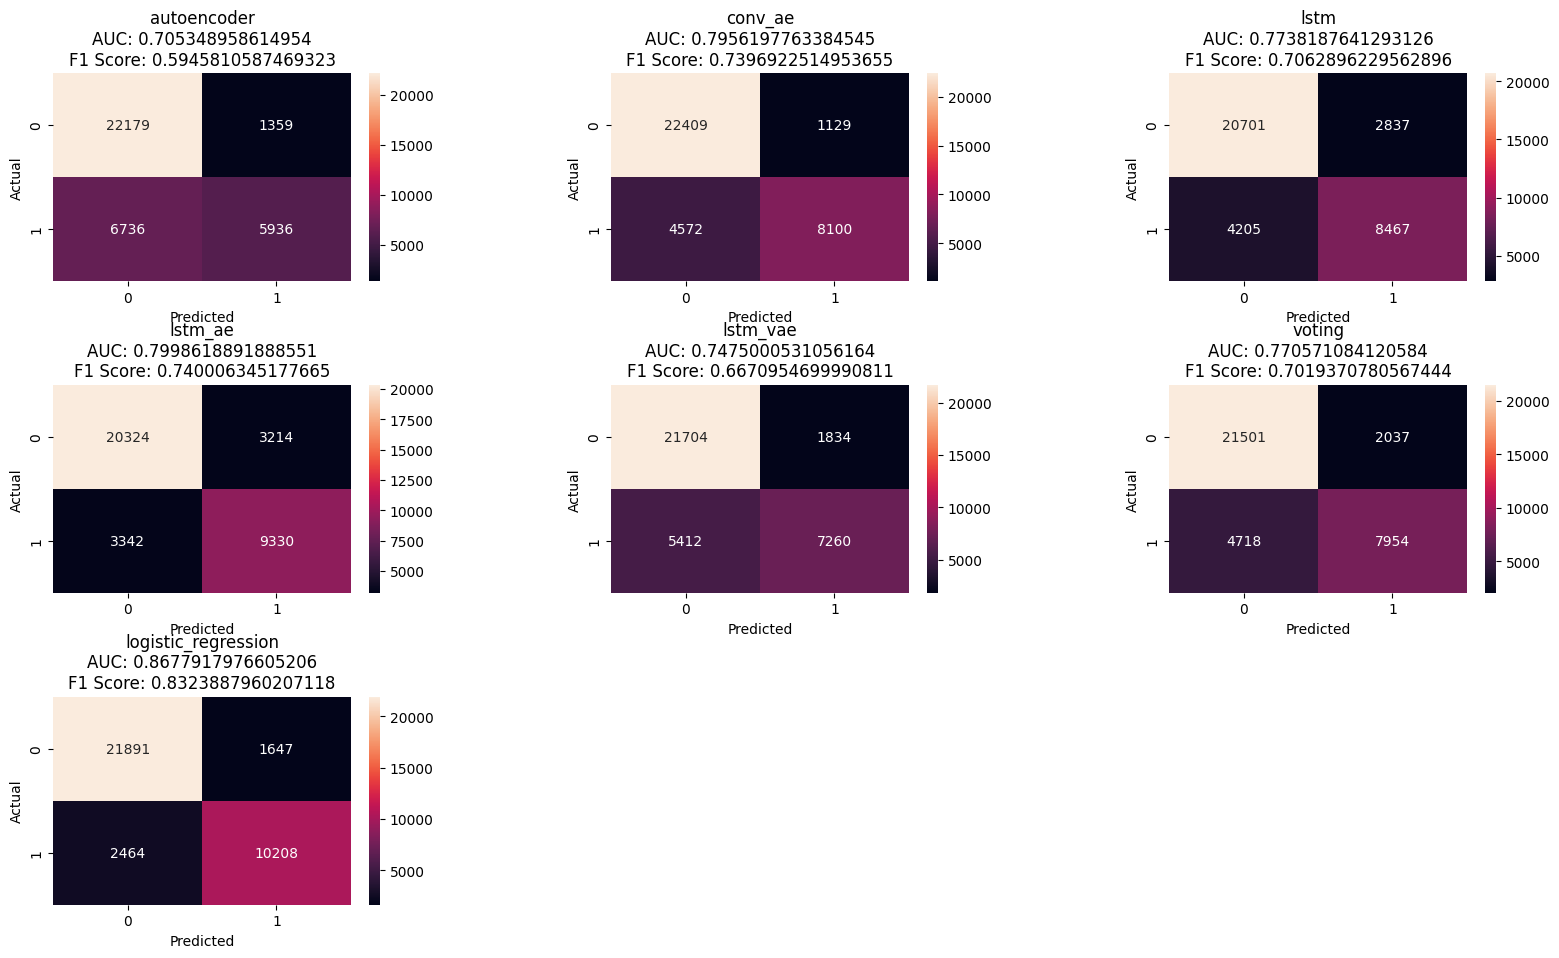

In [9]:
cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", "anomaly_by_lstm_vae", "anomaly_by_voting", "anomaly_by_logistic_regression"]
utils.plot_confusion_matrix_all(final_aggr_pd, "anomaly", *cols)

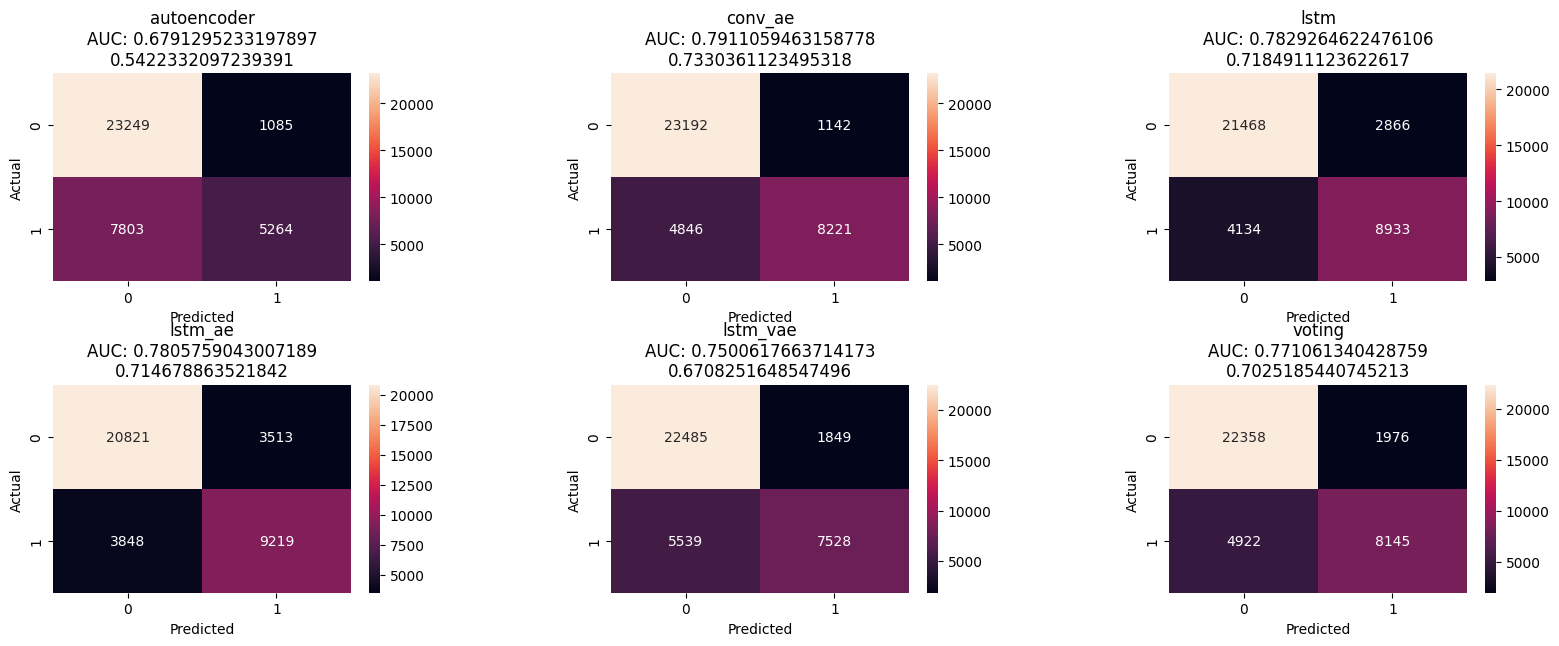

In [ ]:
cols = ["anomaly_by_autoencoder", "anomaly_by_conv_ae", "anomaly_by_lstm", "anomaly_by_lstm_ae", "anomaly_by_lstm_vae", "anomaly_by_voting"]
utils.plot_confusion_matrix_all(final_aggr_pd, "anomaly", *cols)

### Test Table with Images

C:\Users\anastasis\AppData\Local\Temp\ipykernel_13472\1886792940.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)



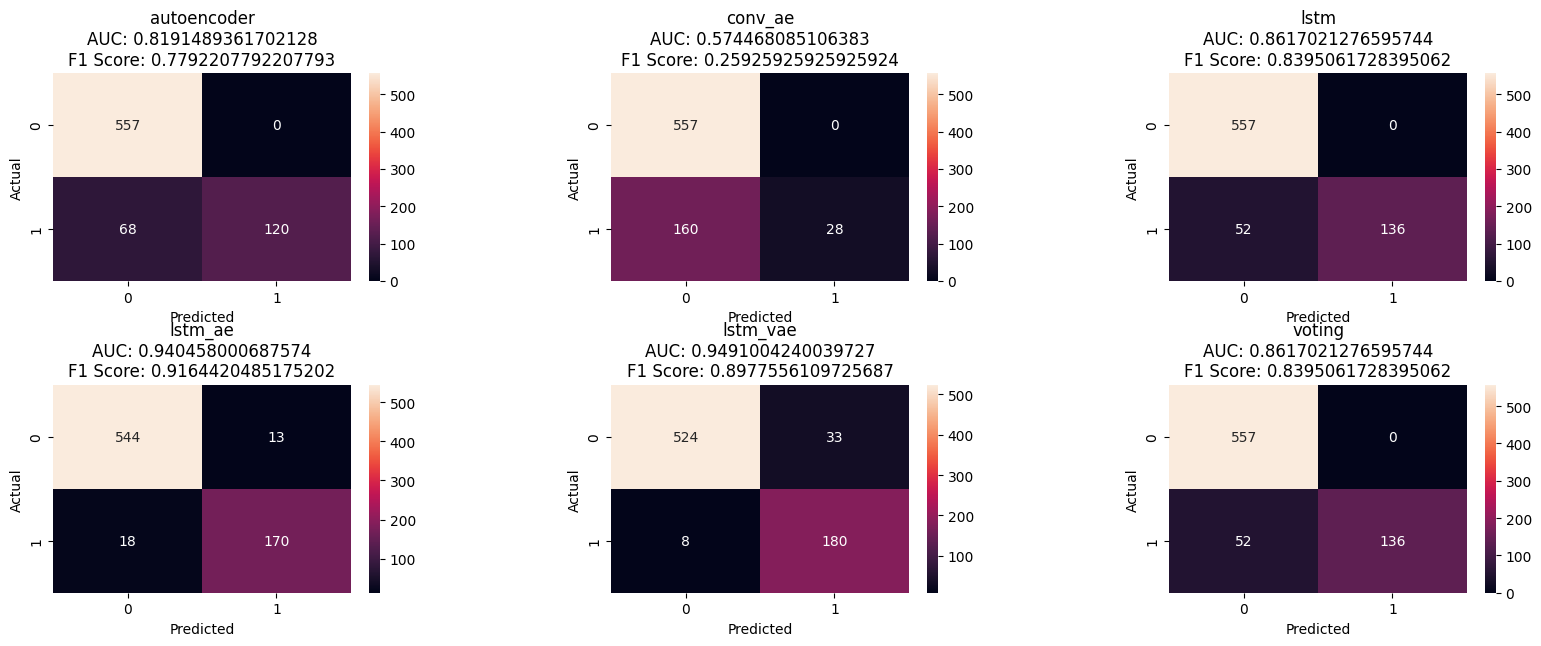
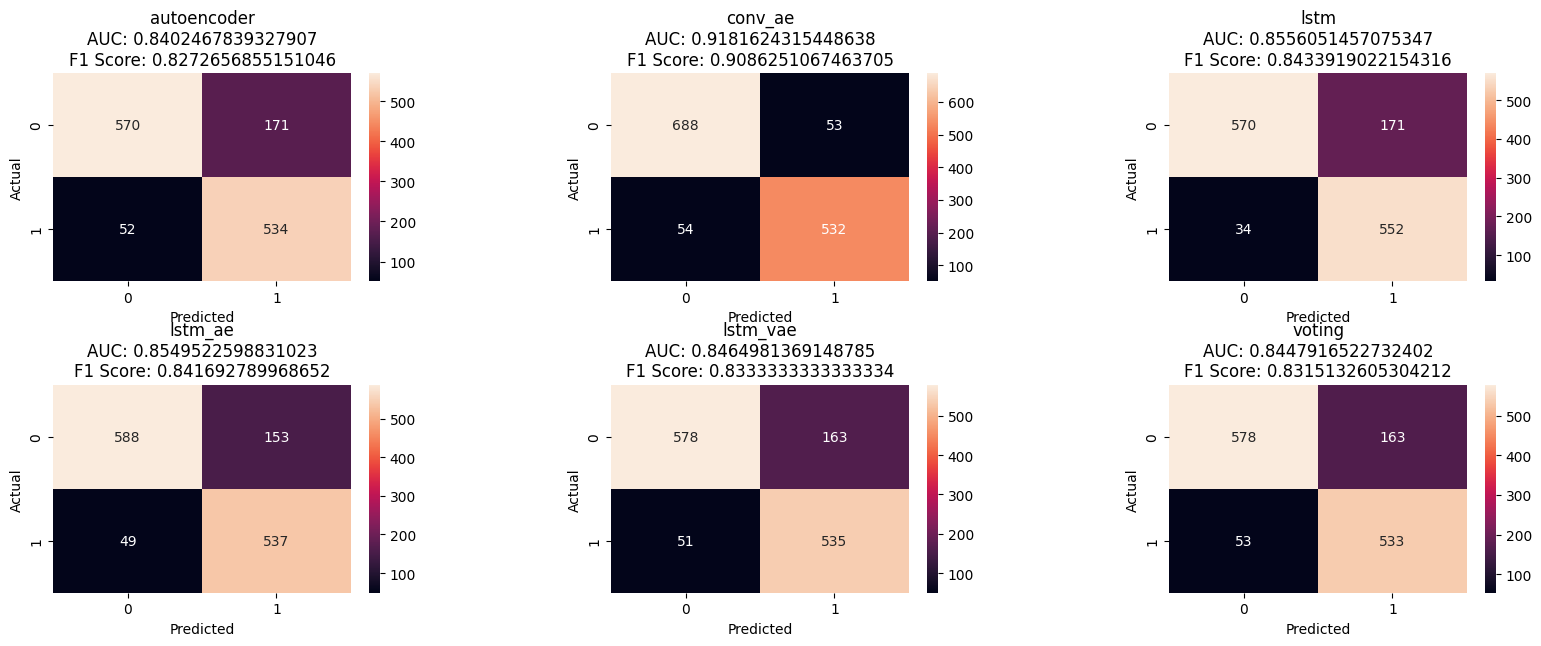
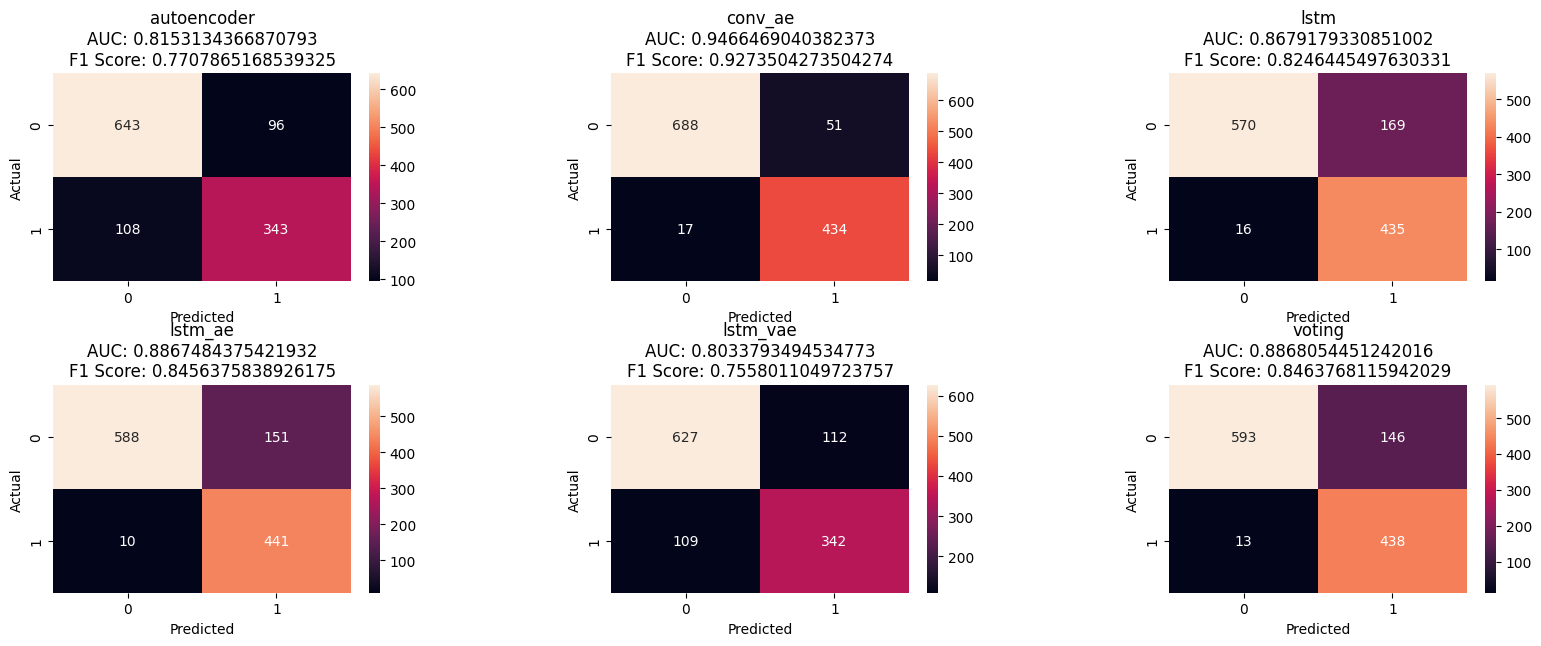
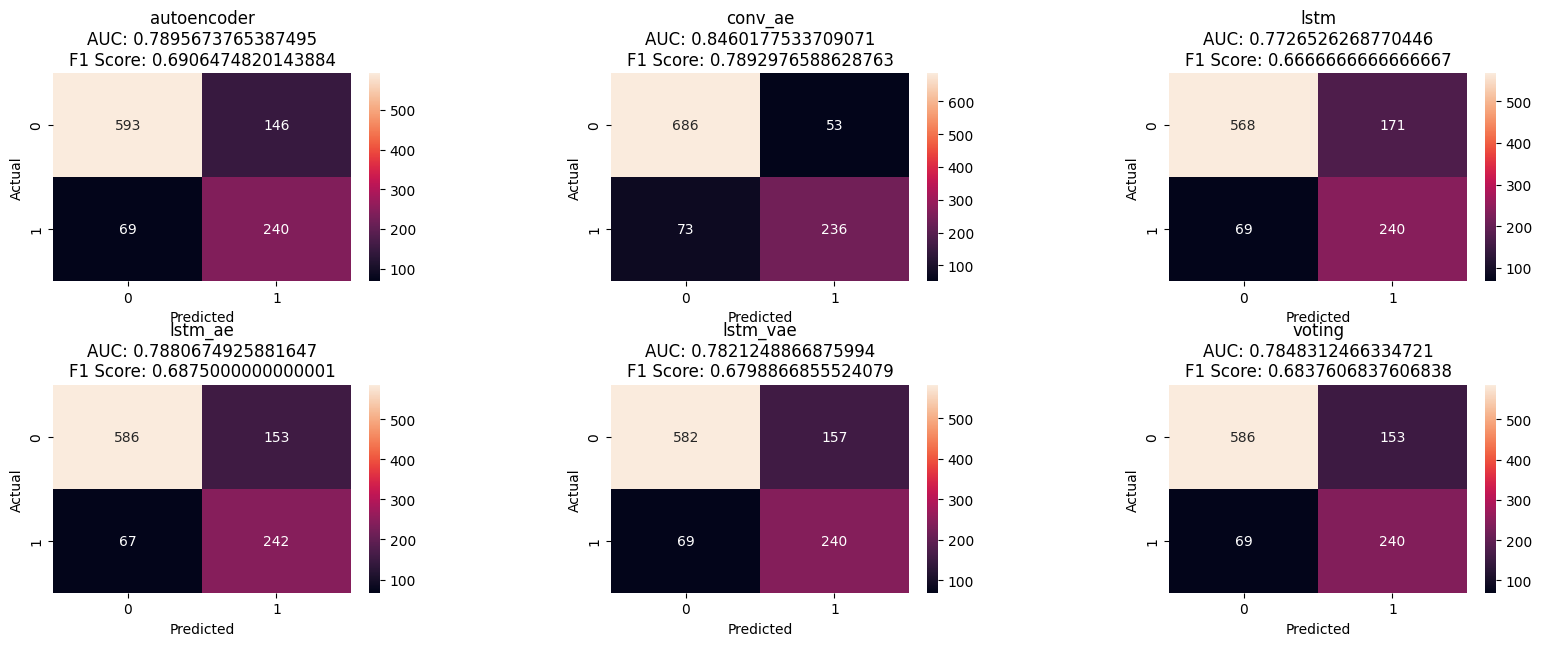
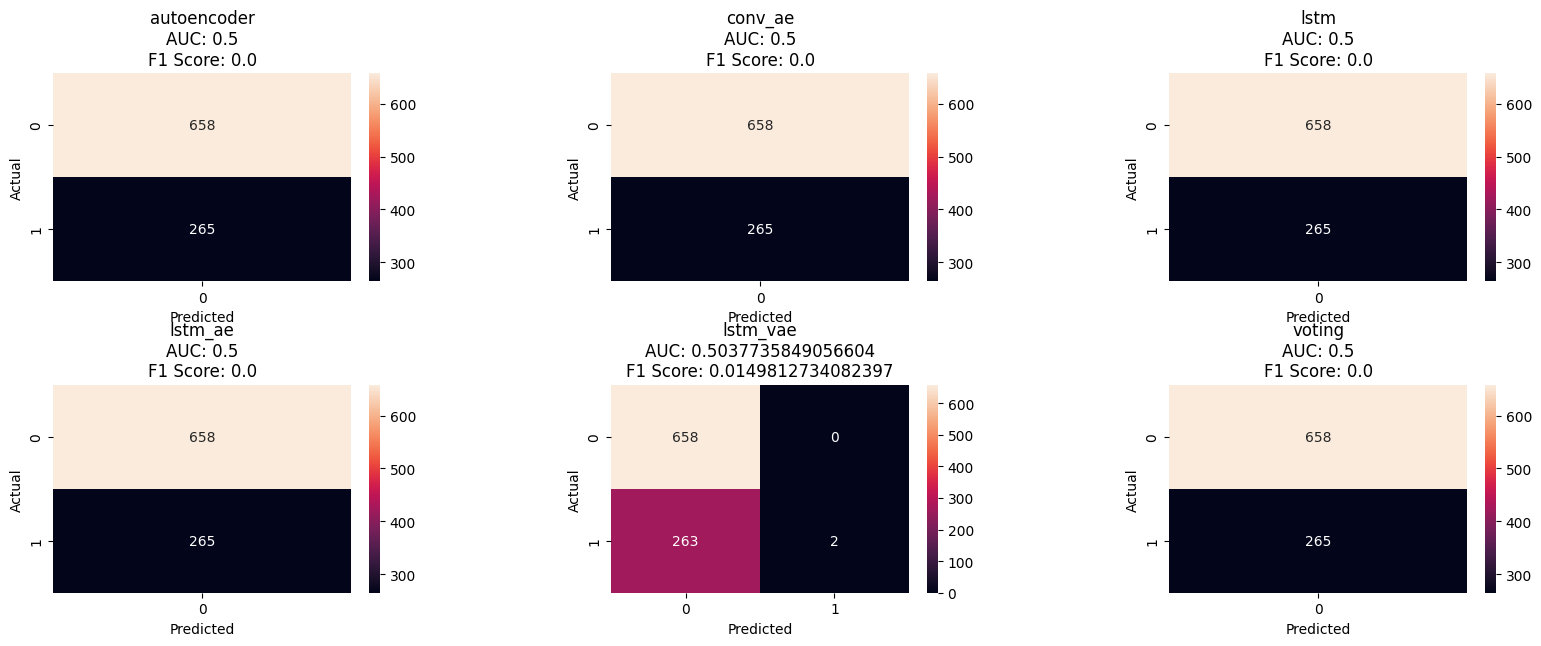
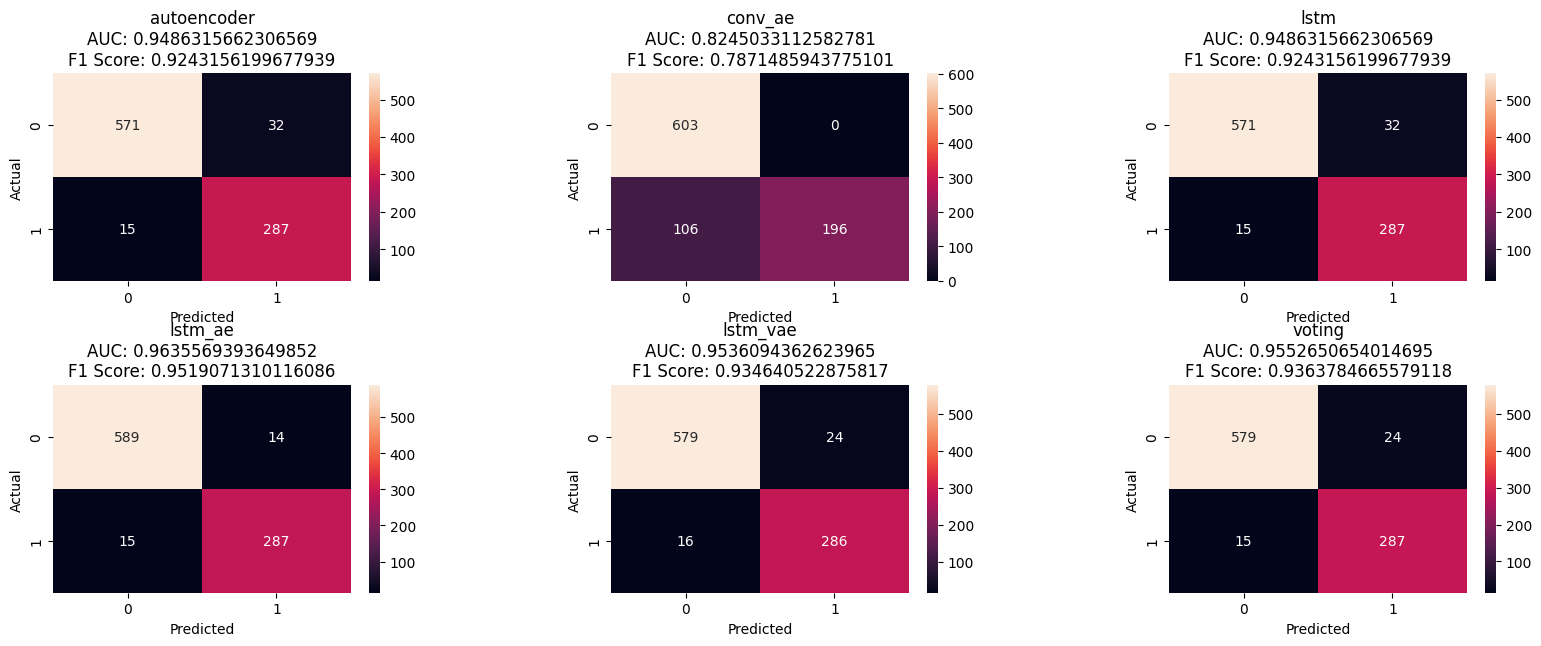
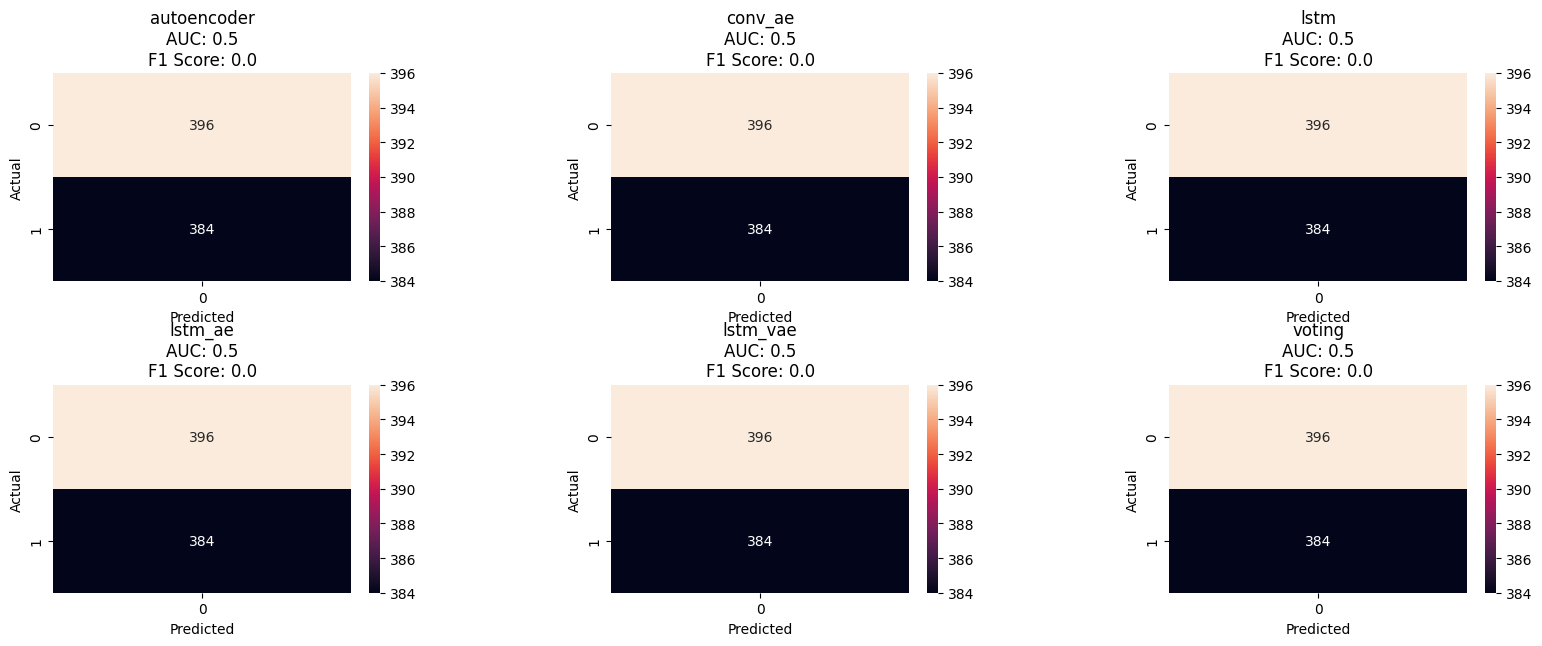
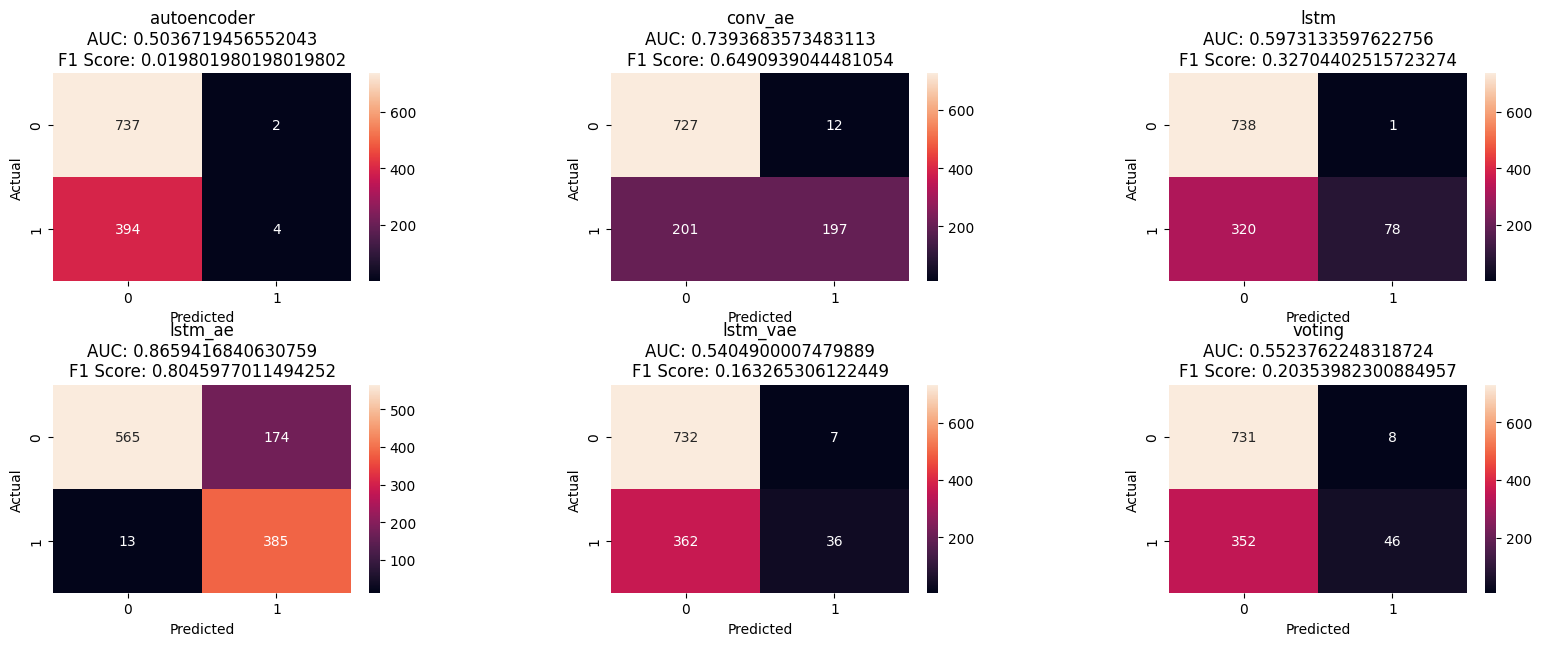
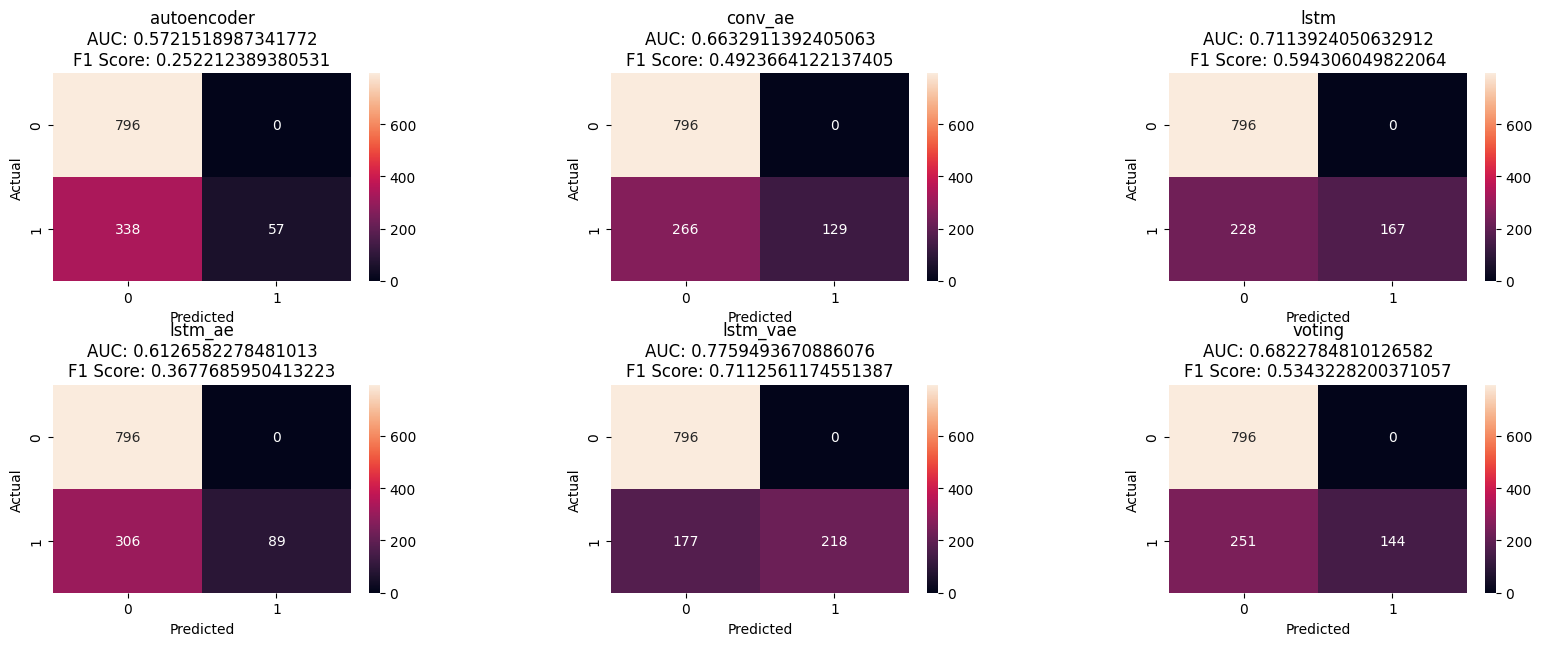
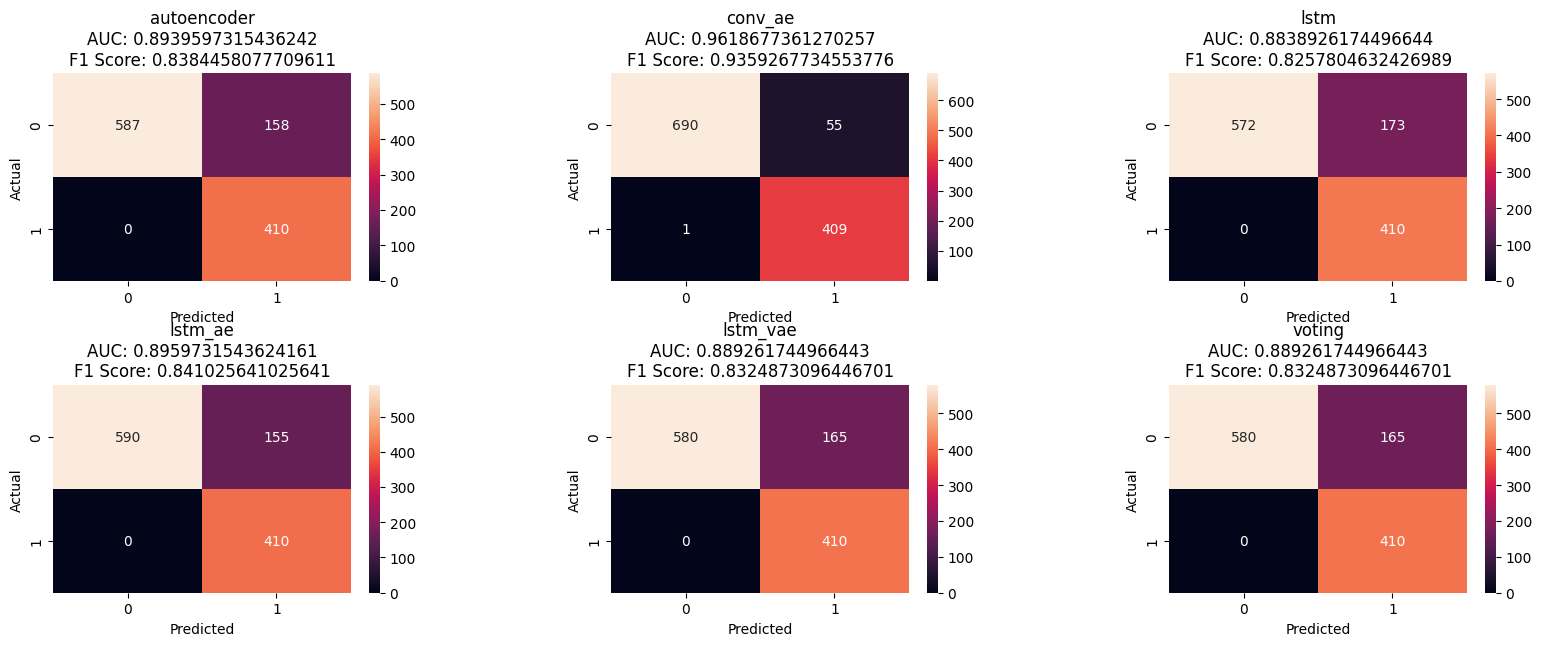
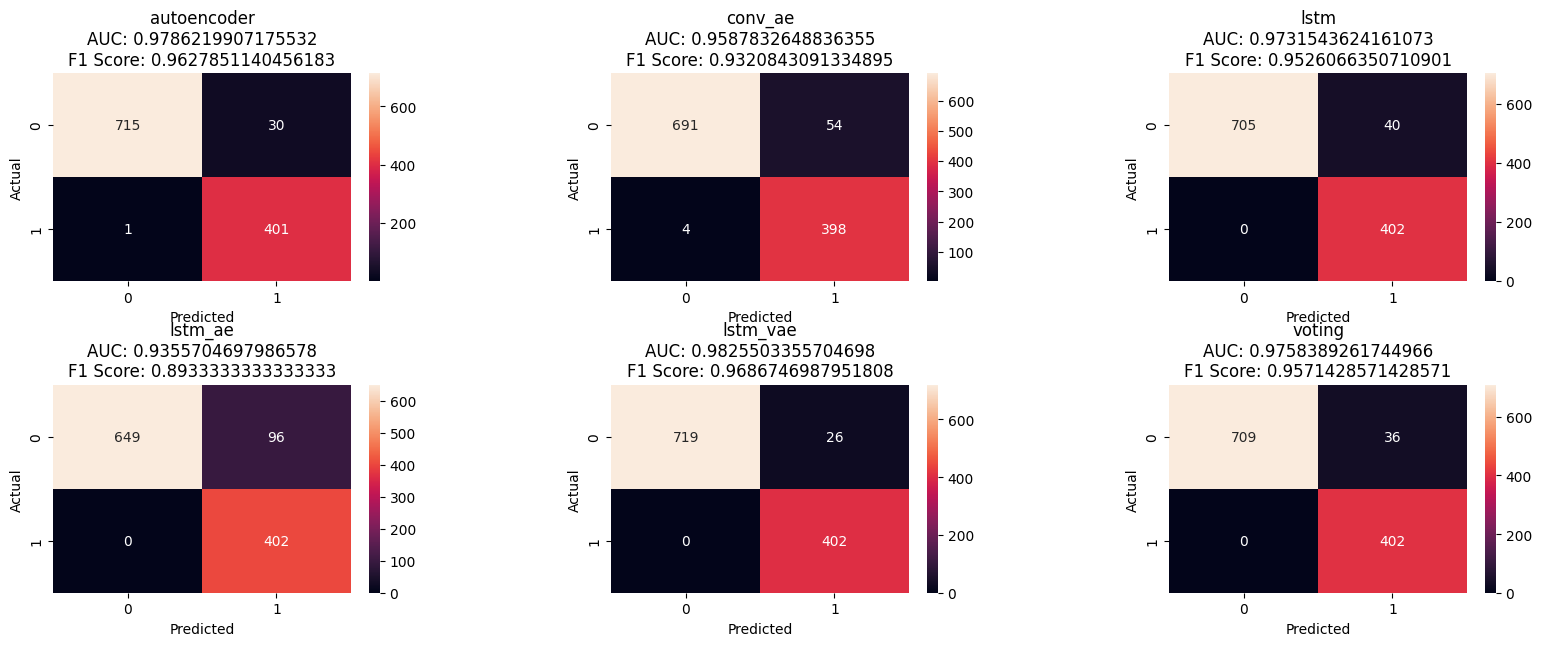
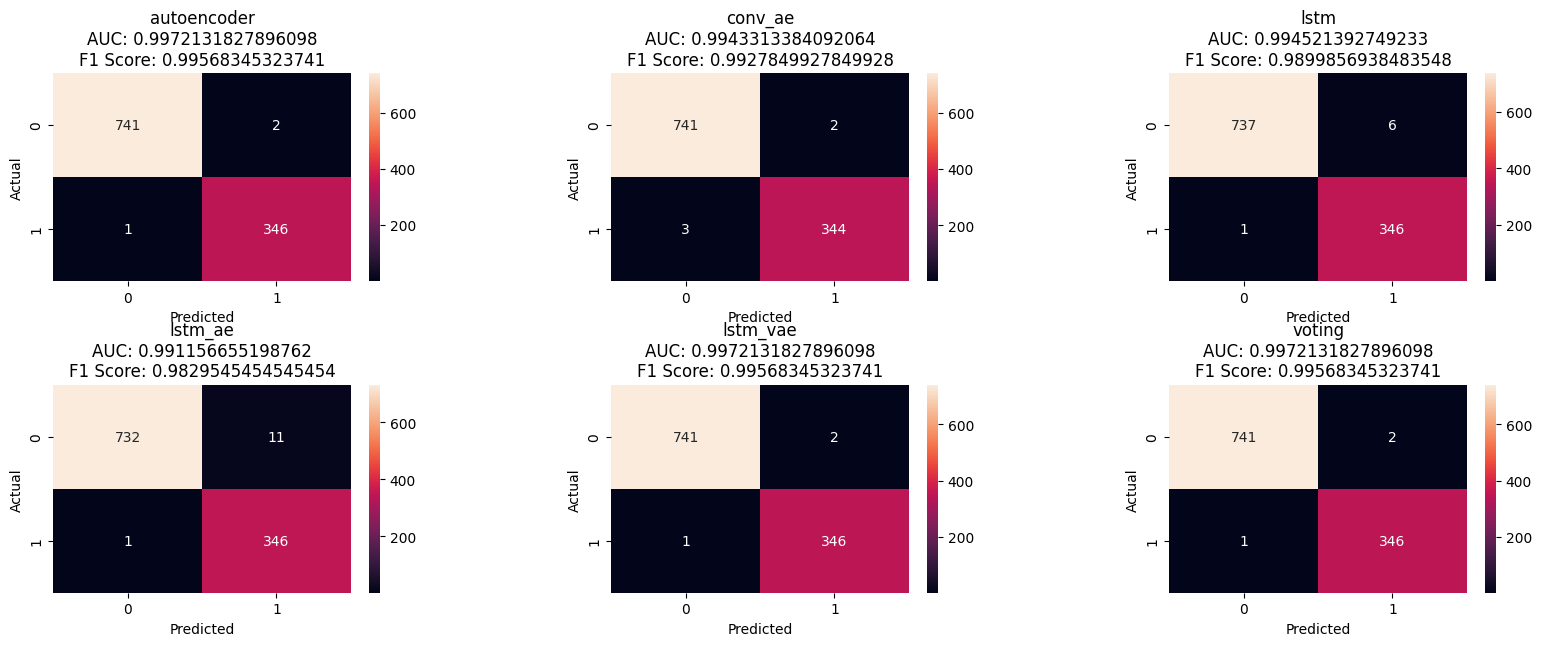
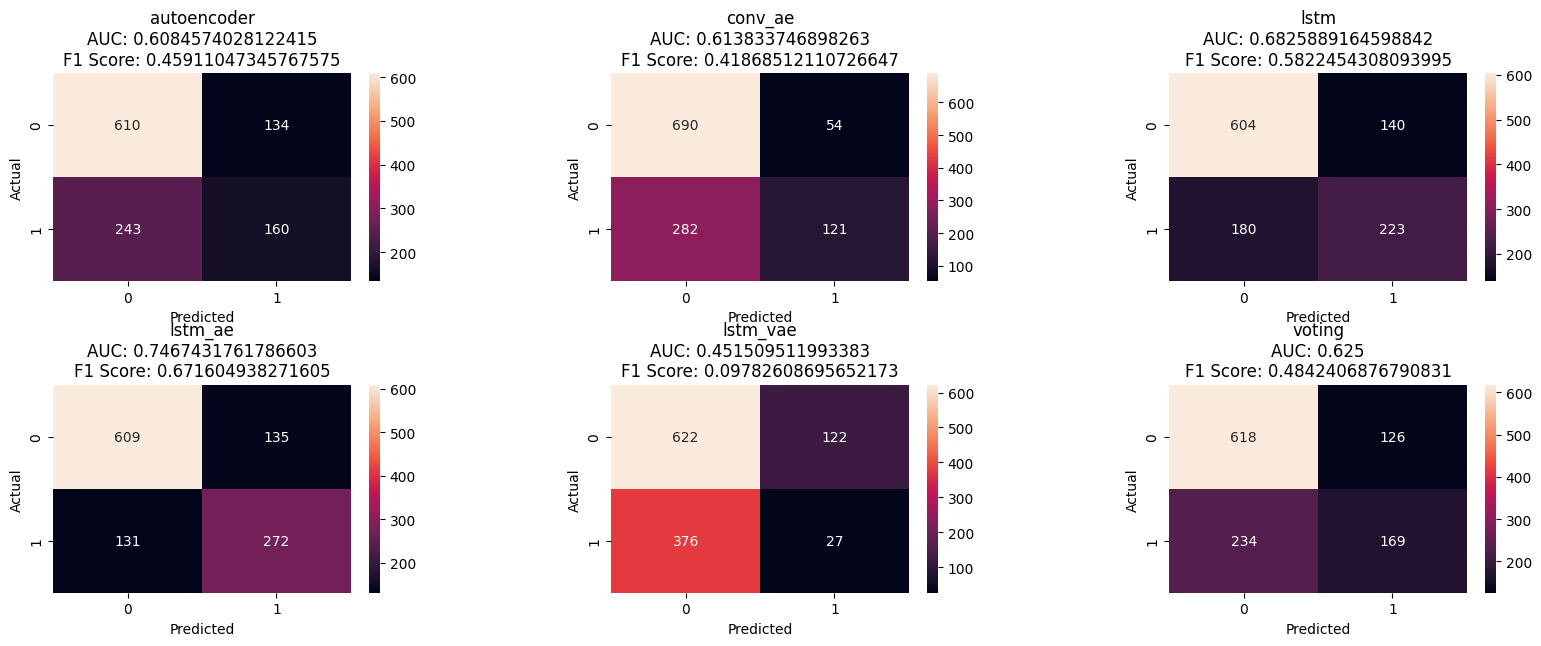
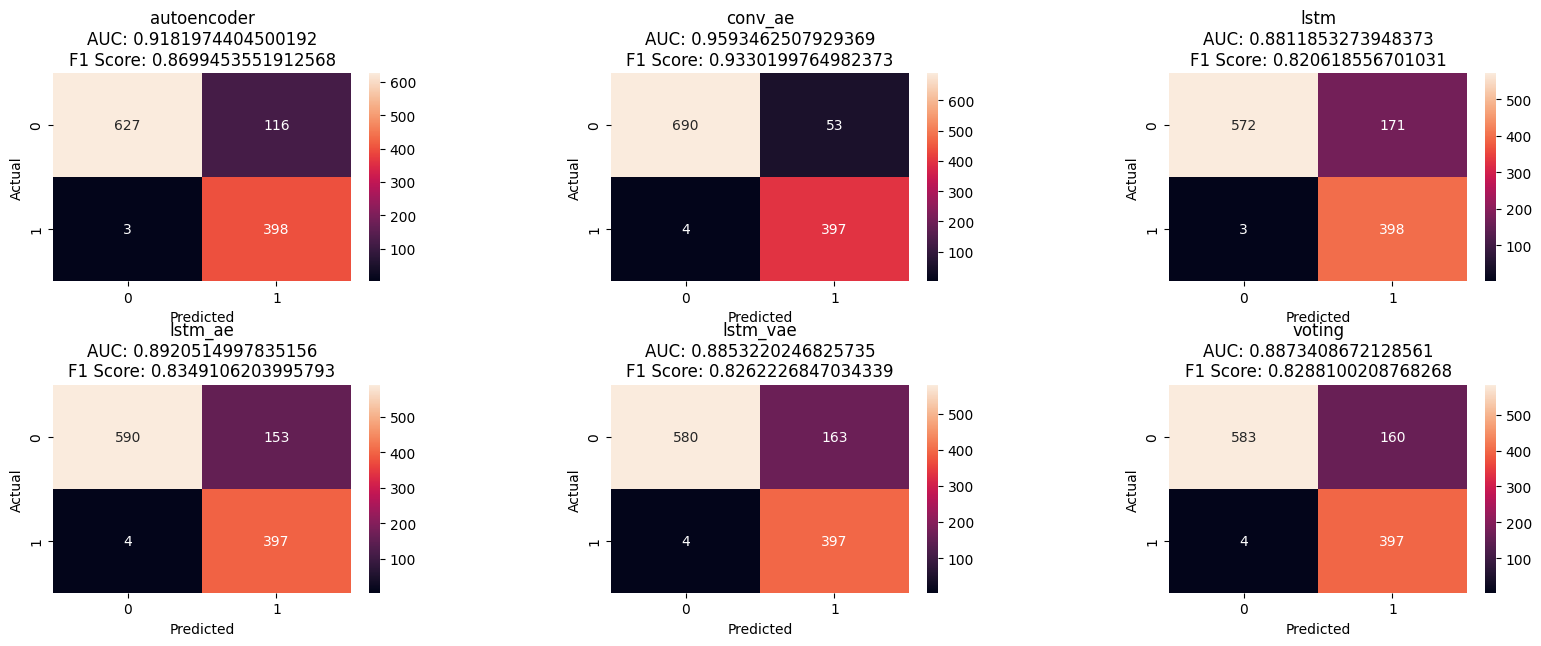
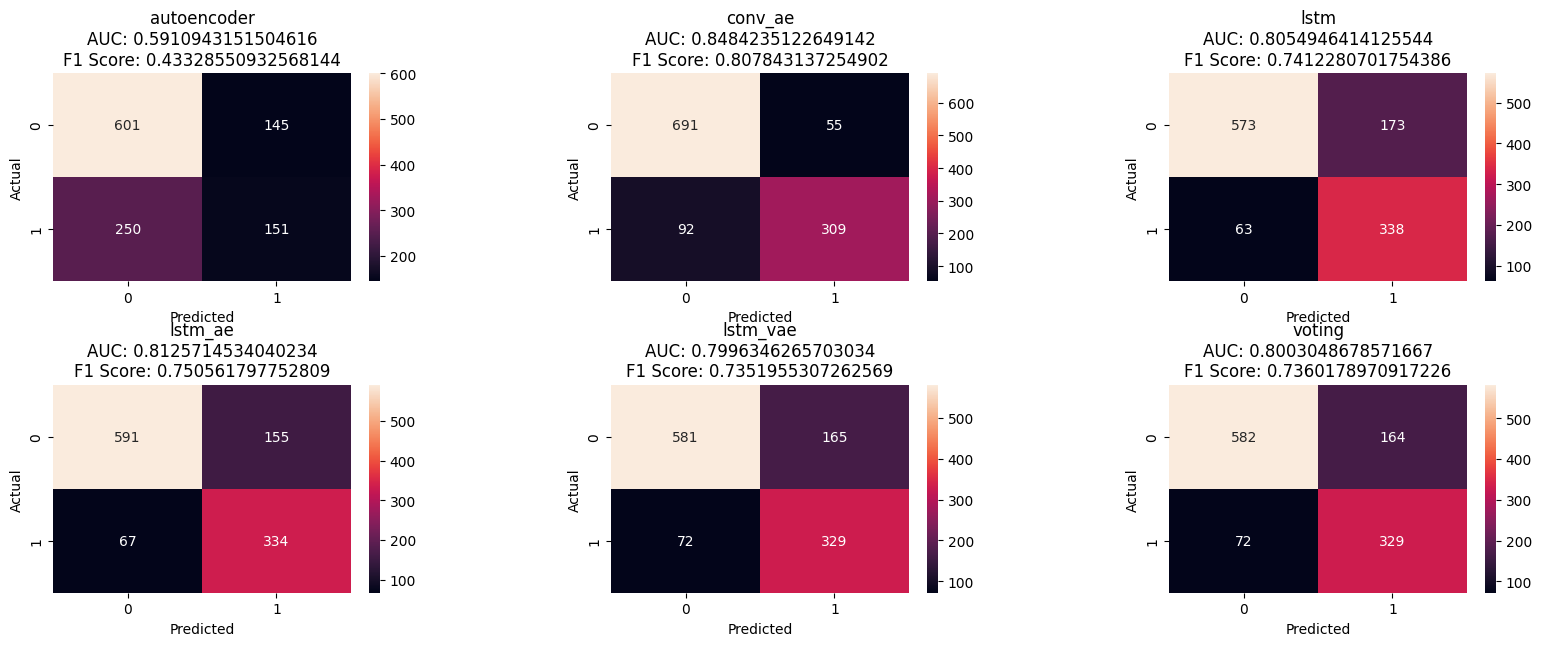
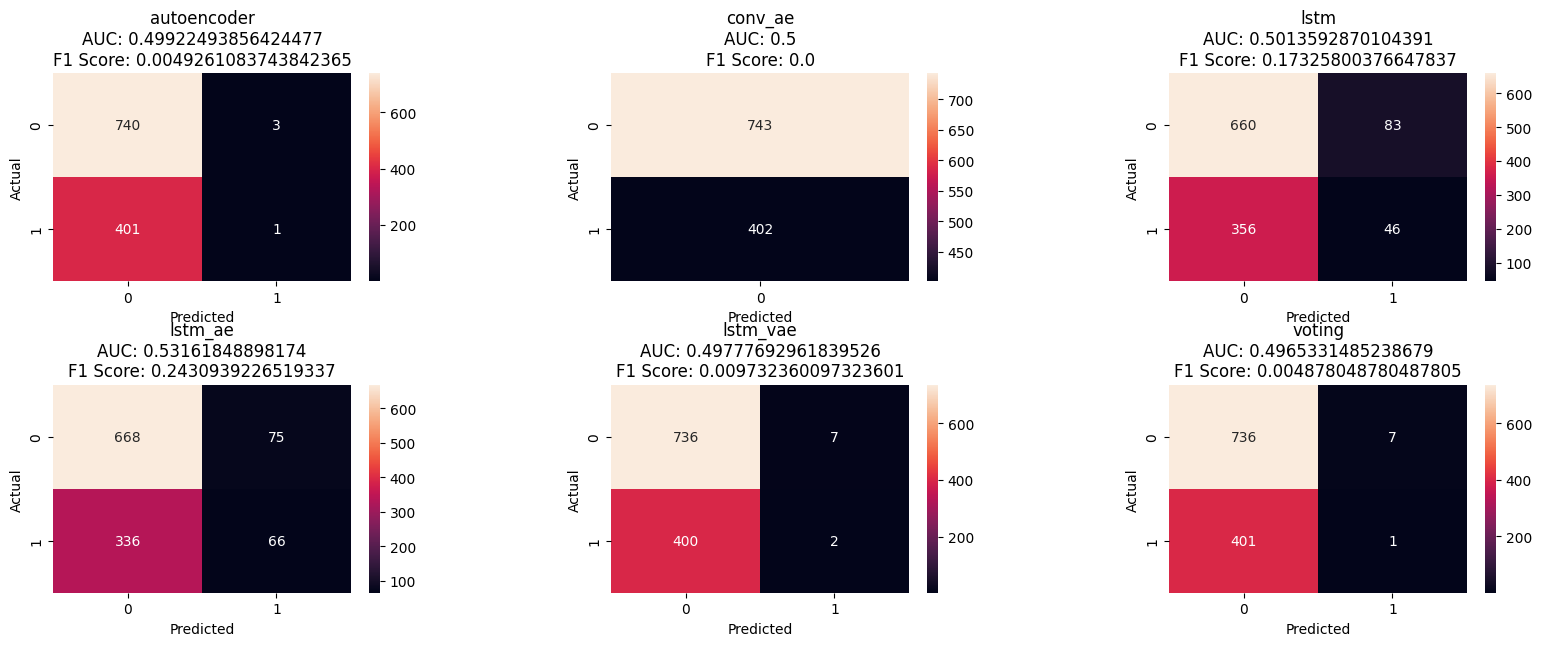
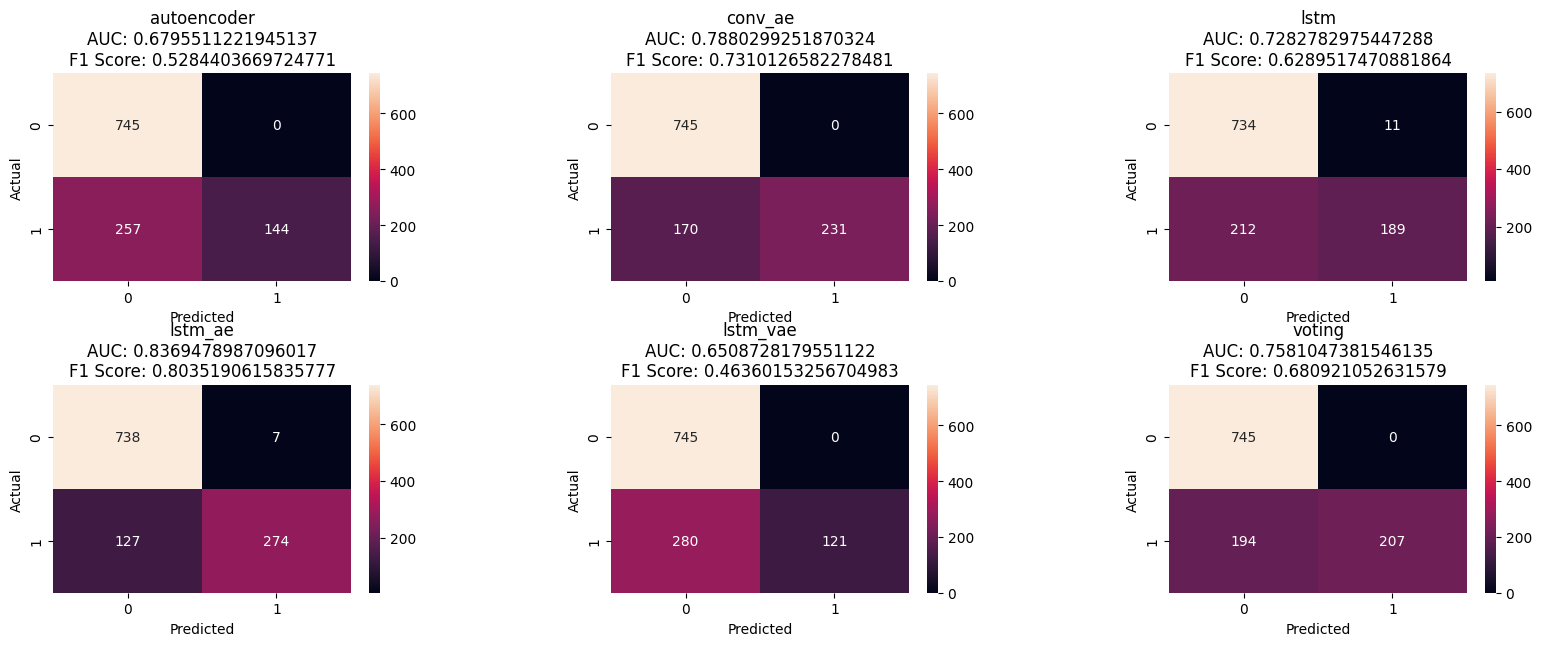
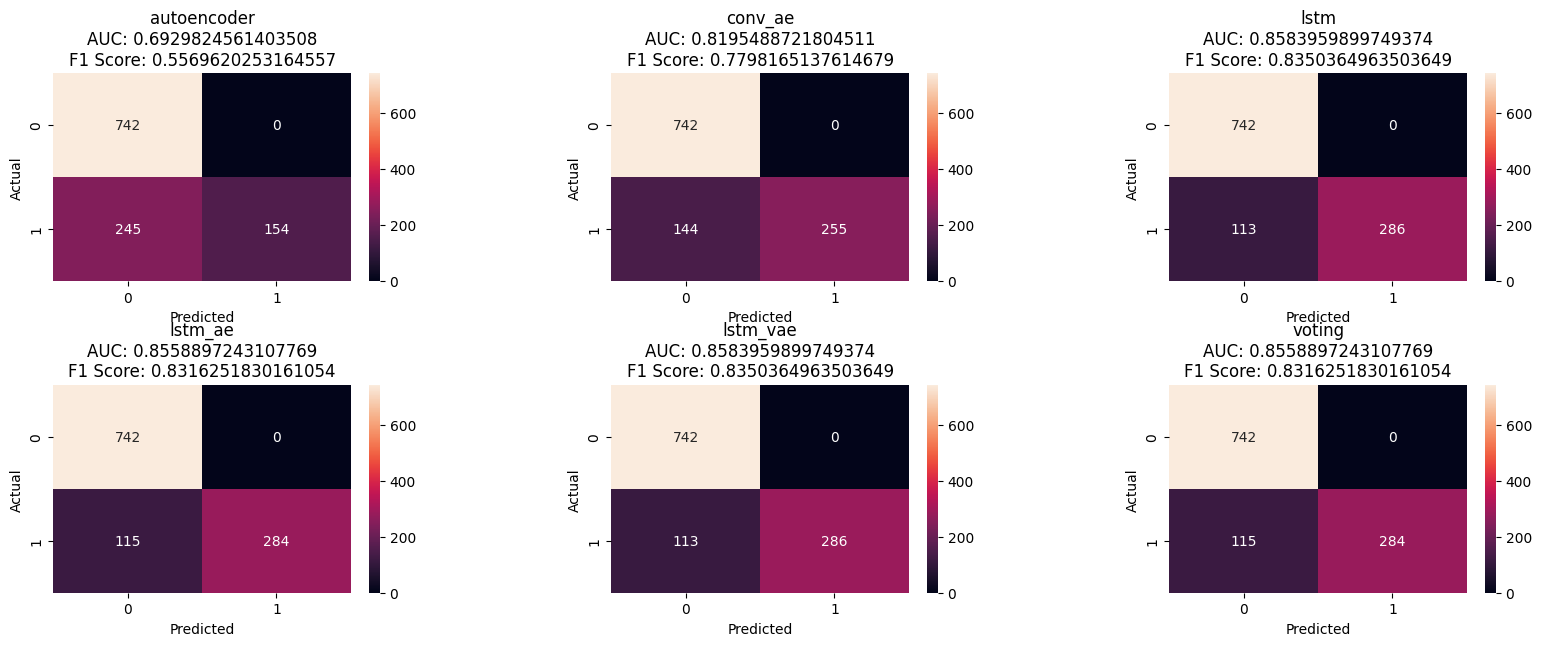
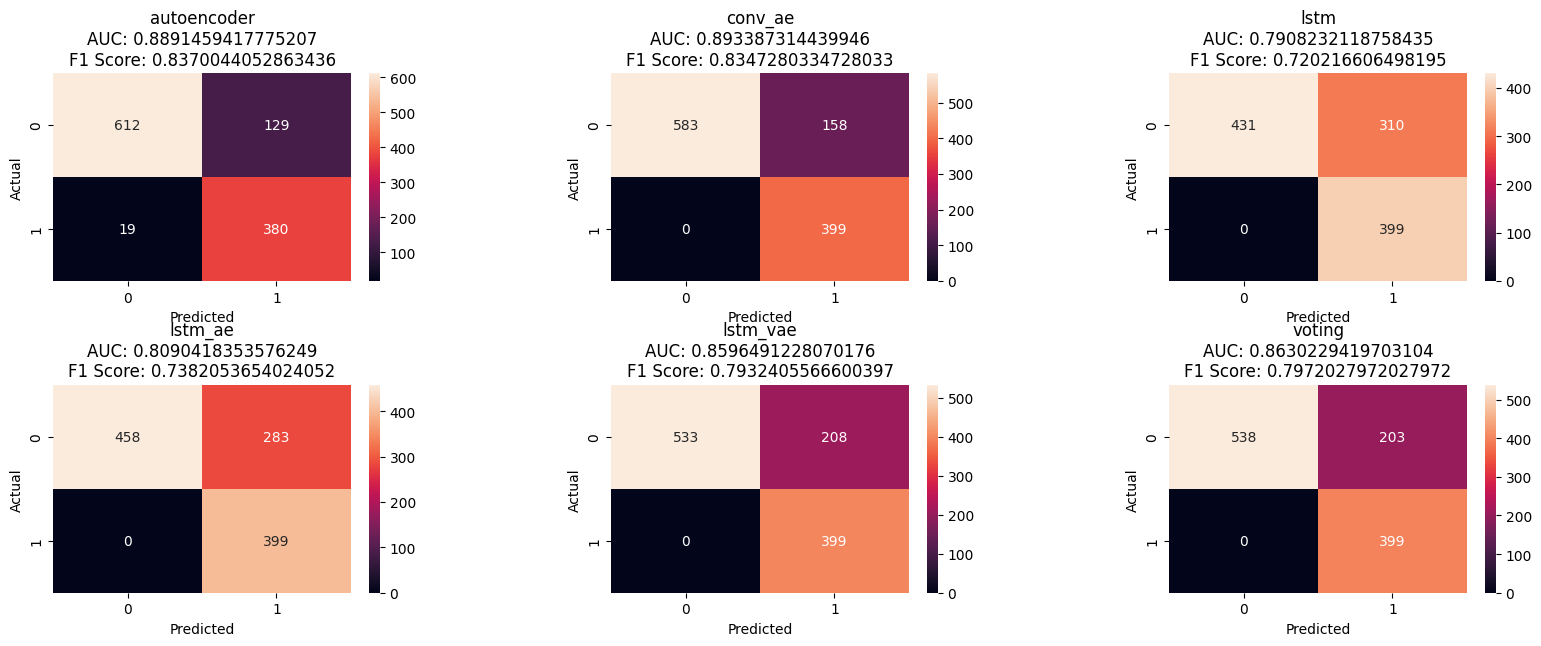
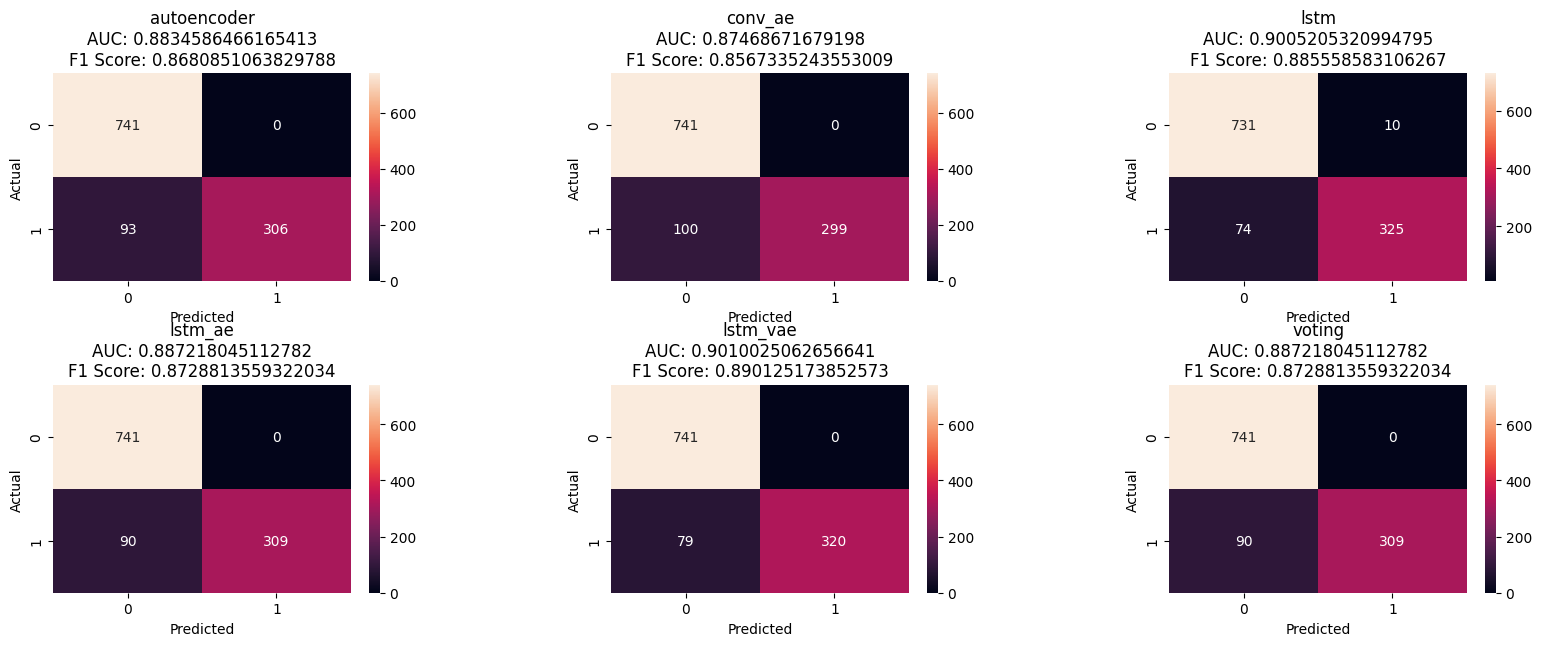
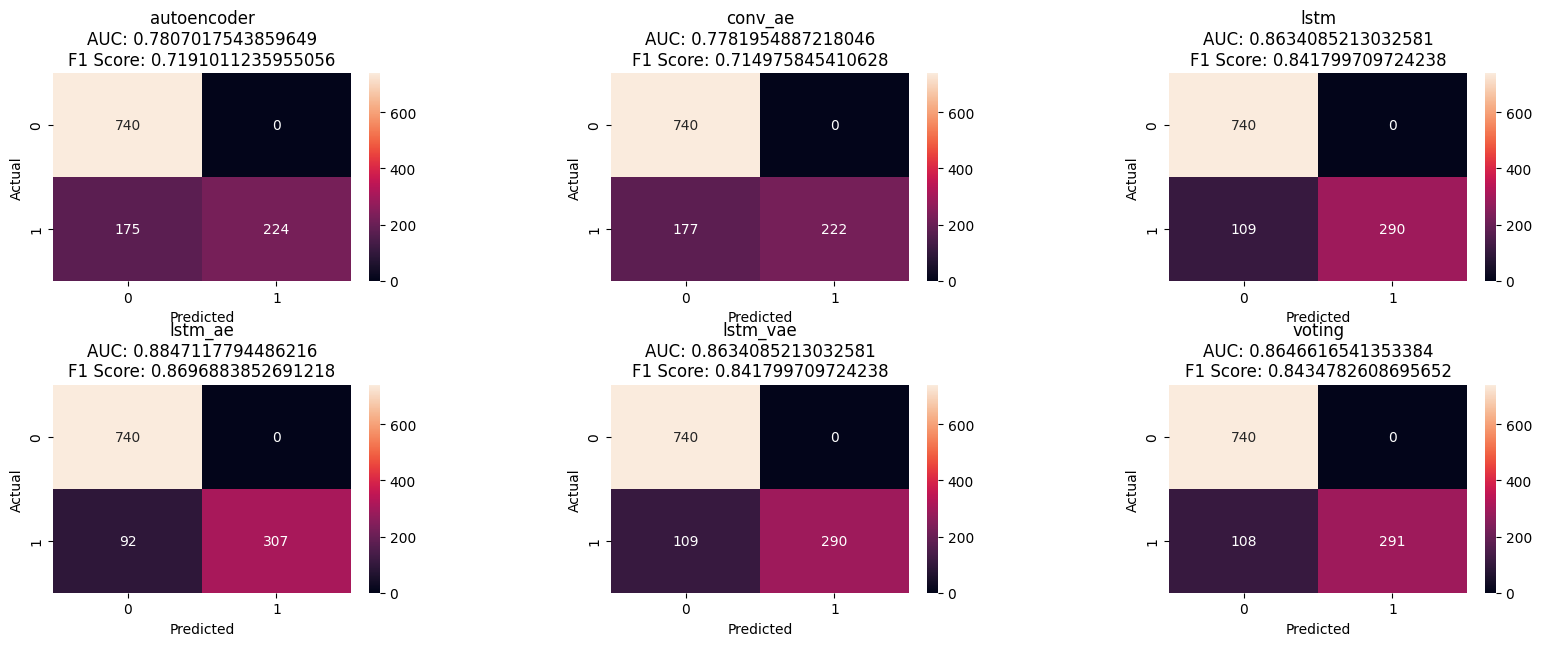
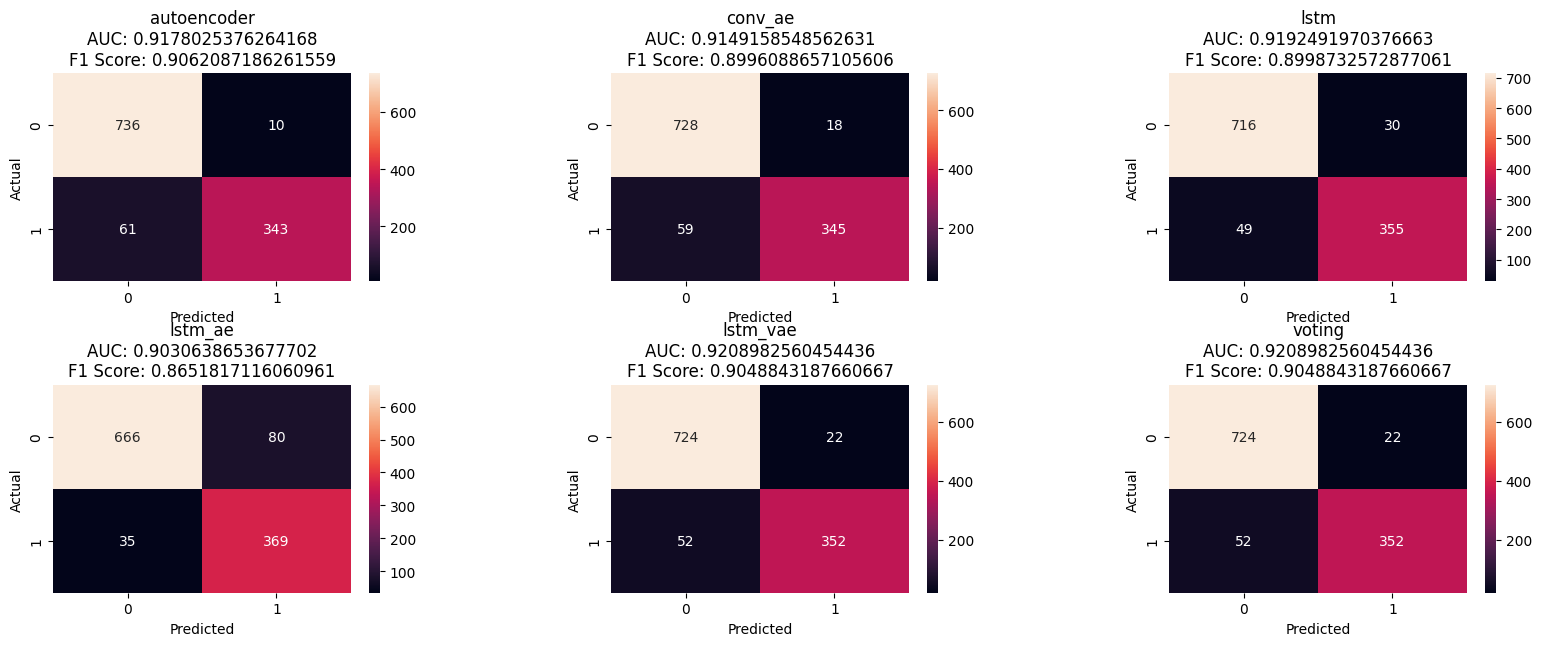
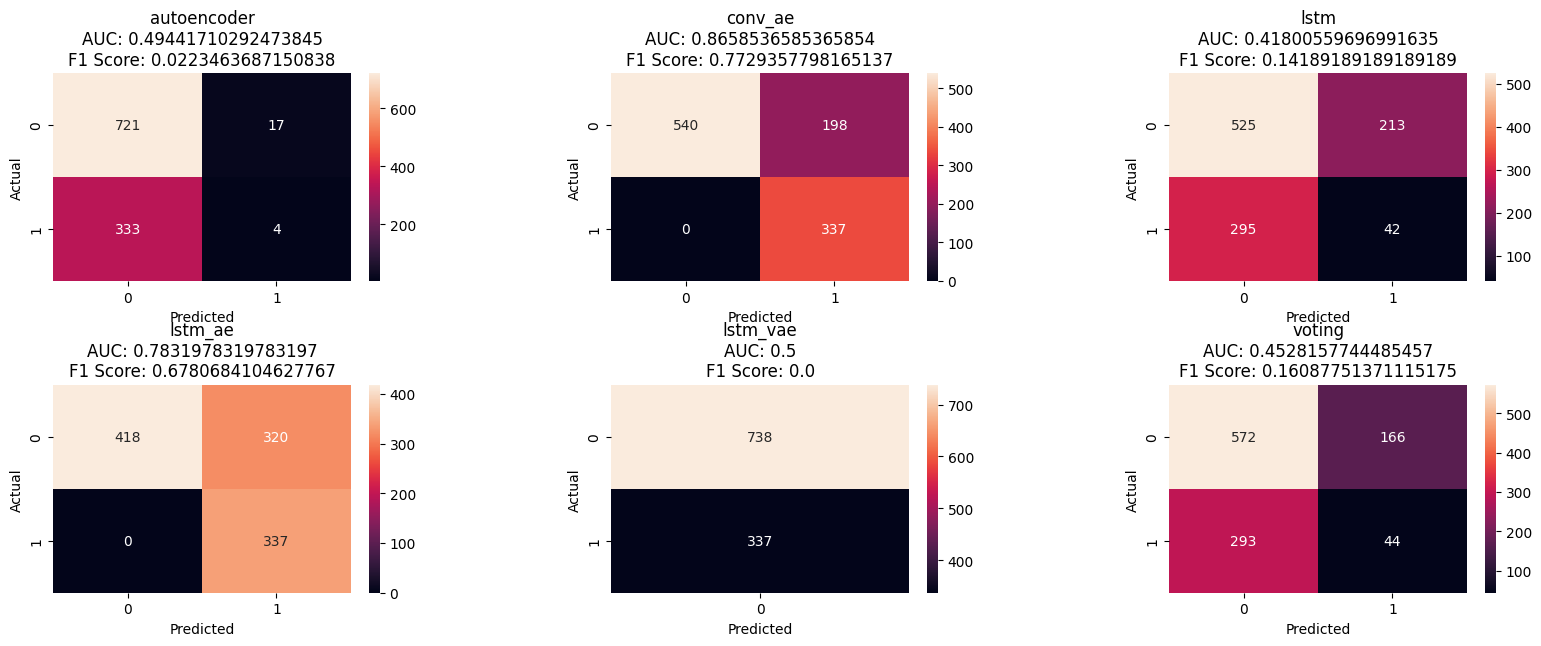
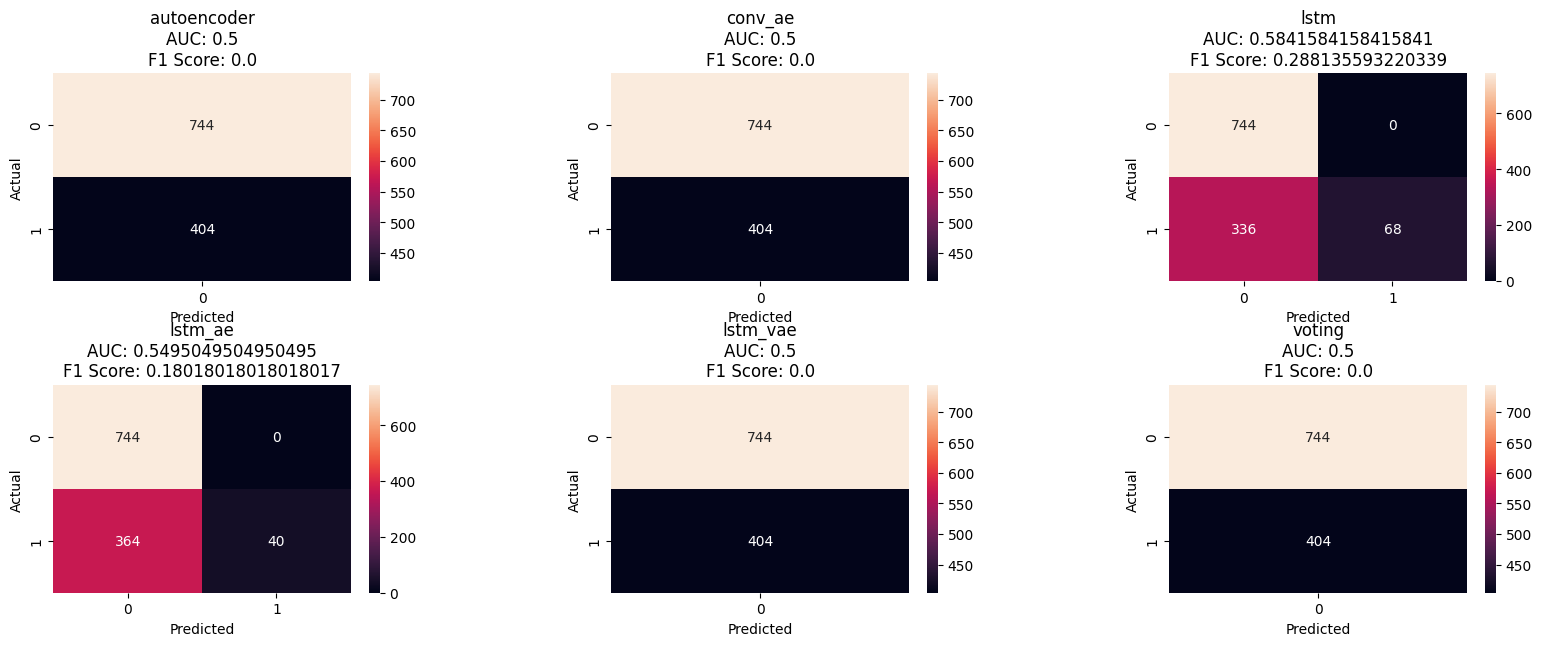
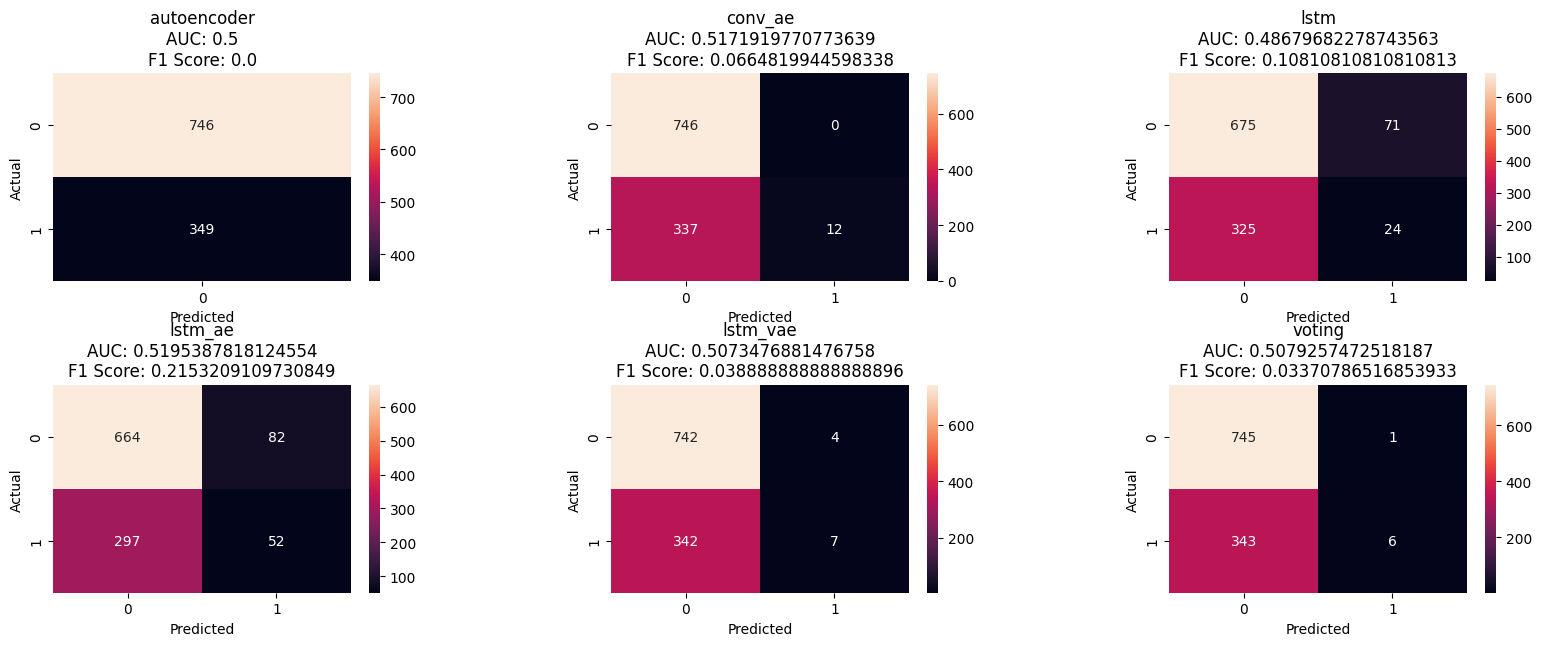
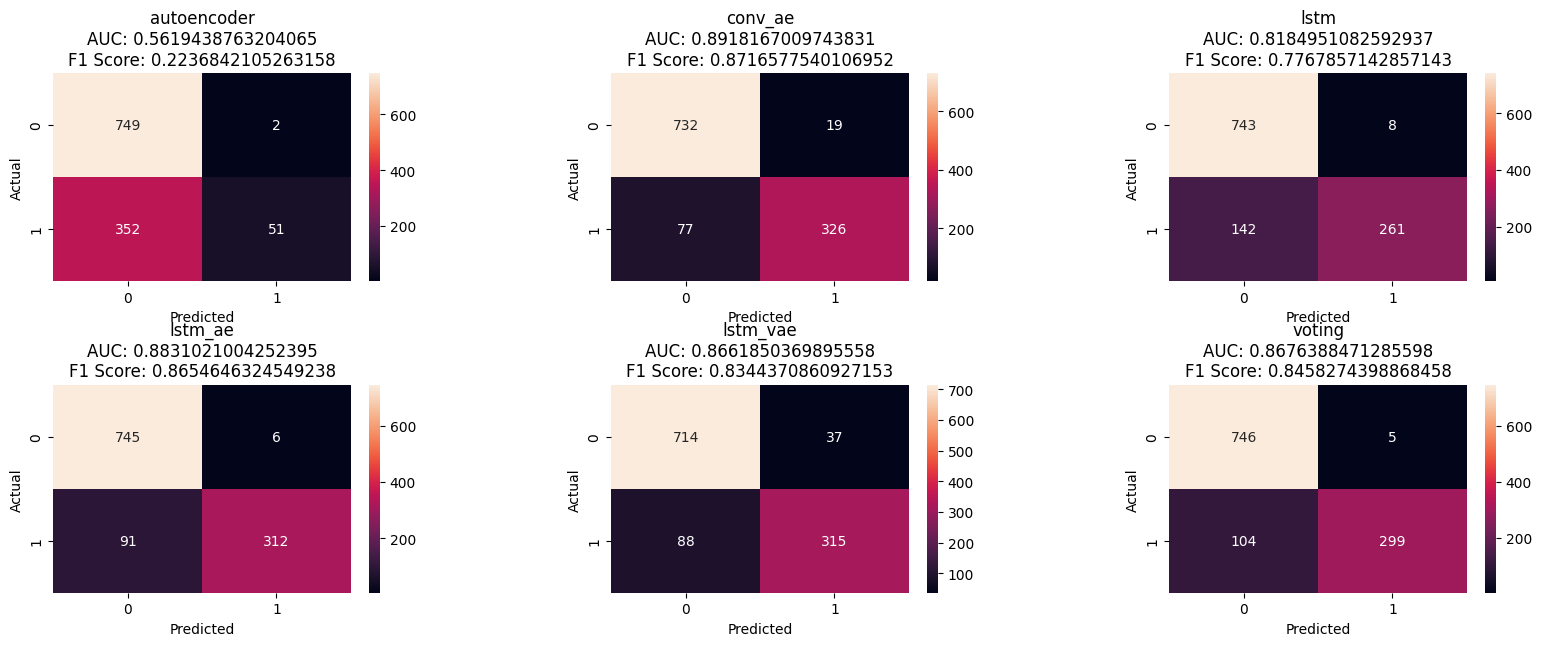
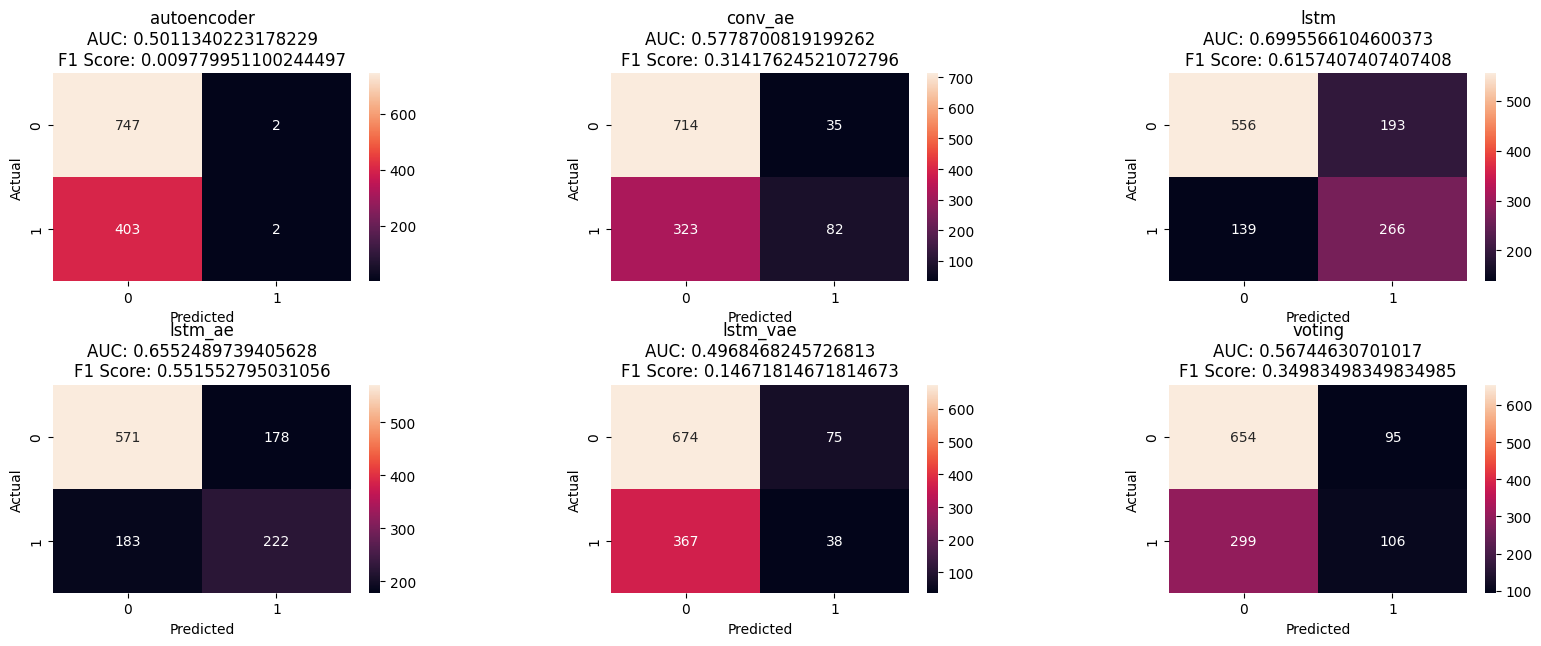
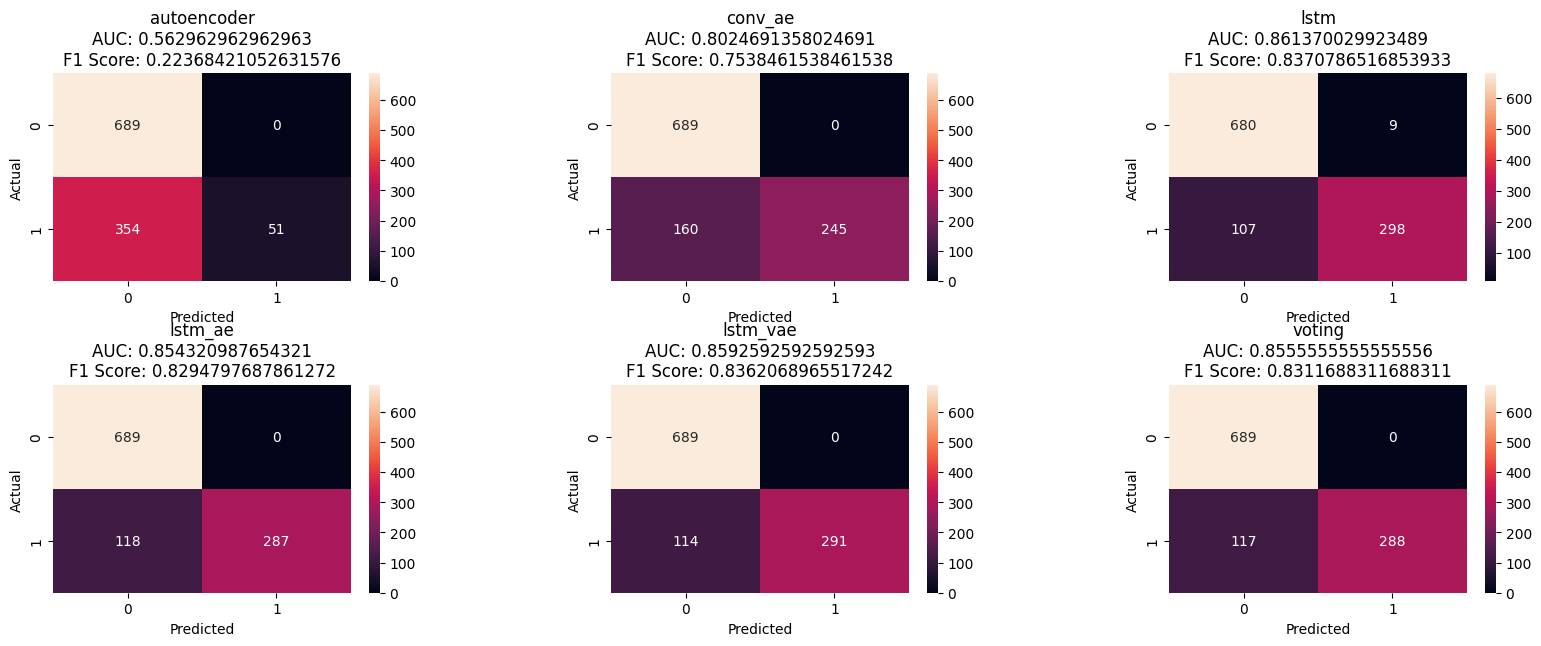
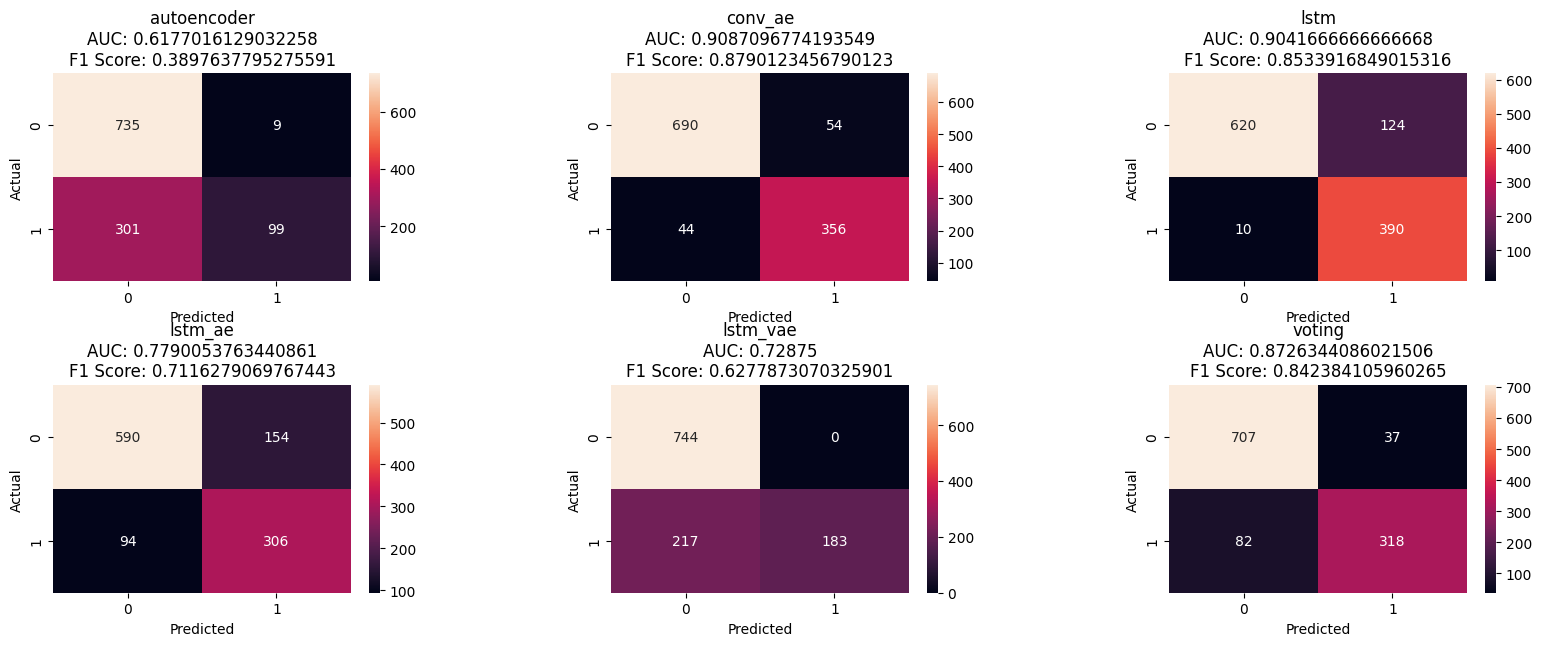
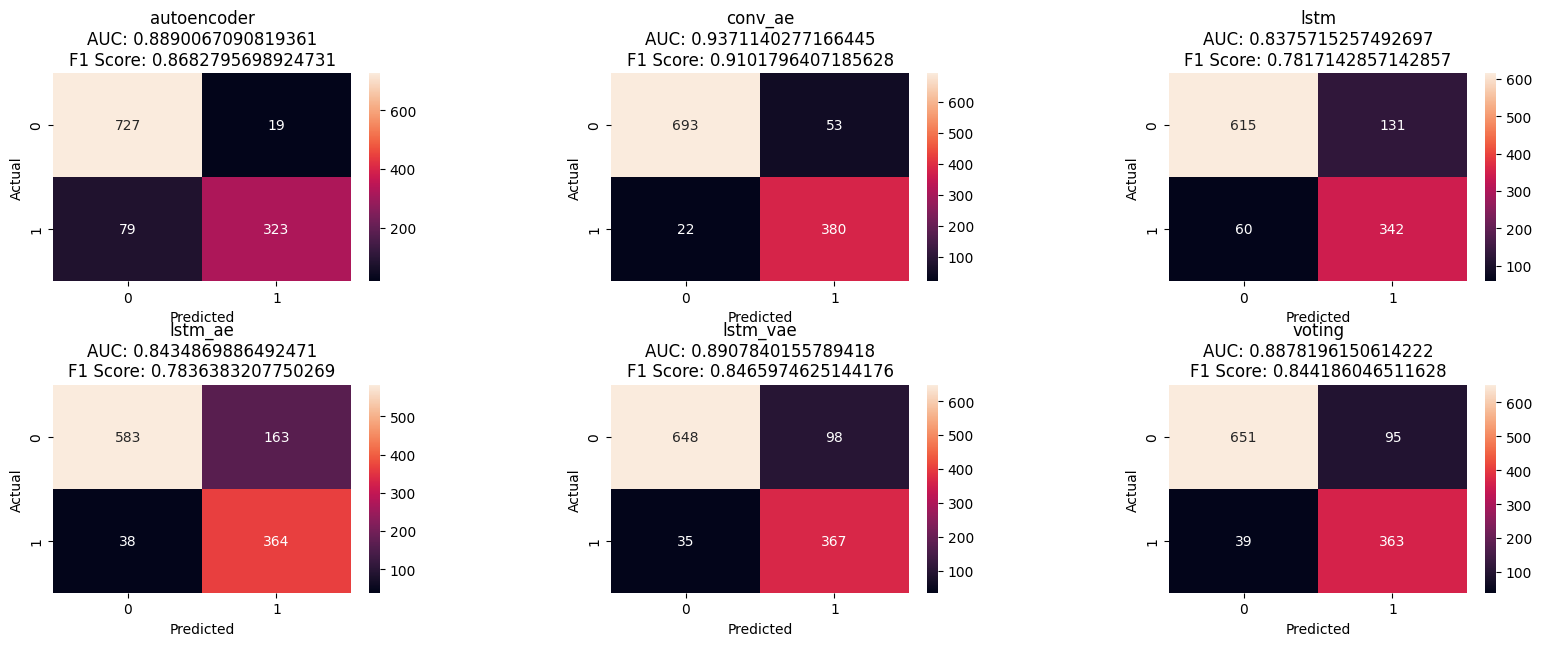
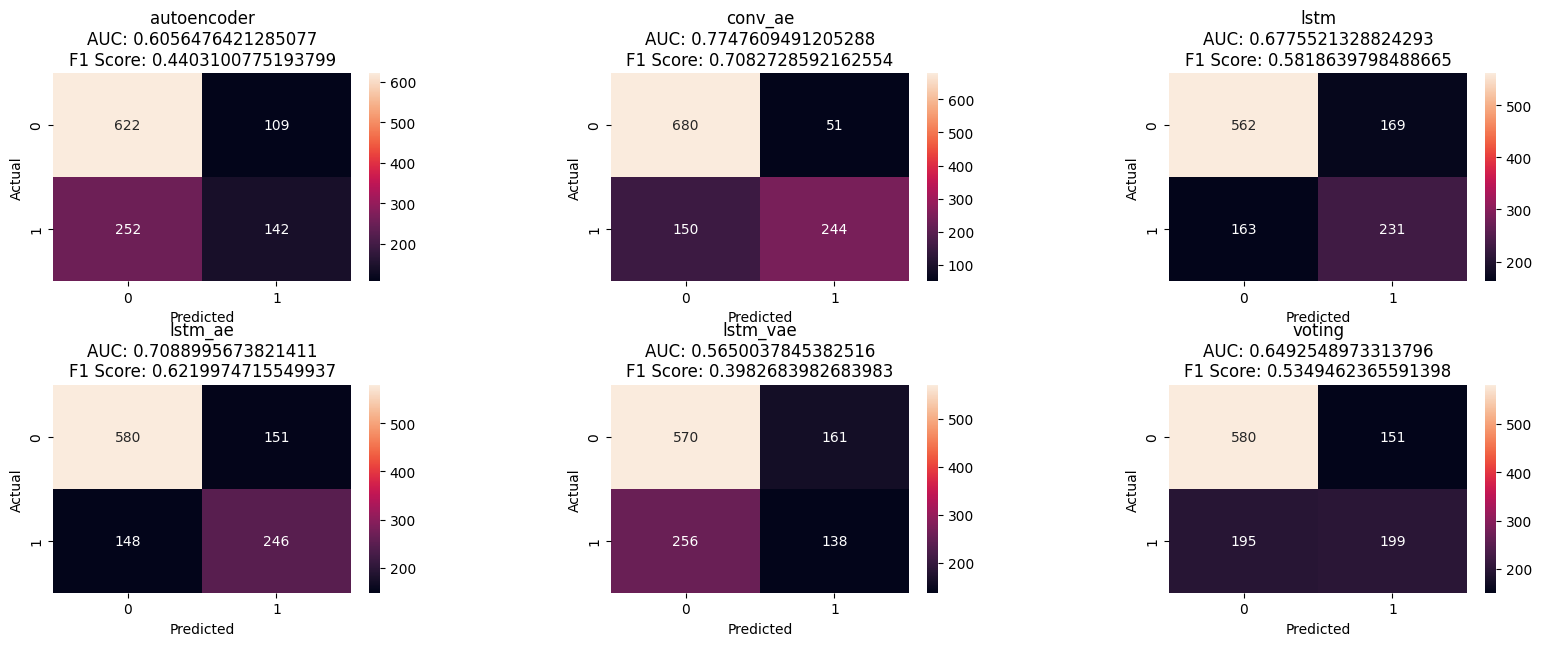
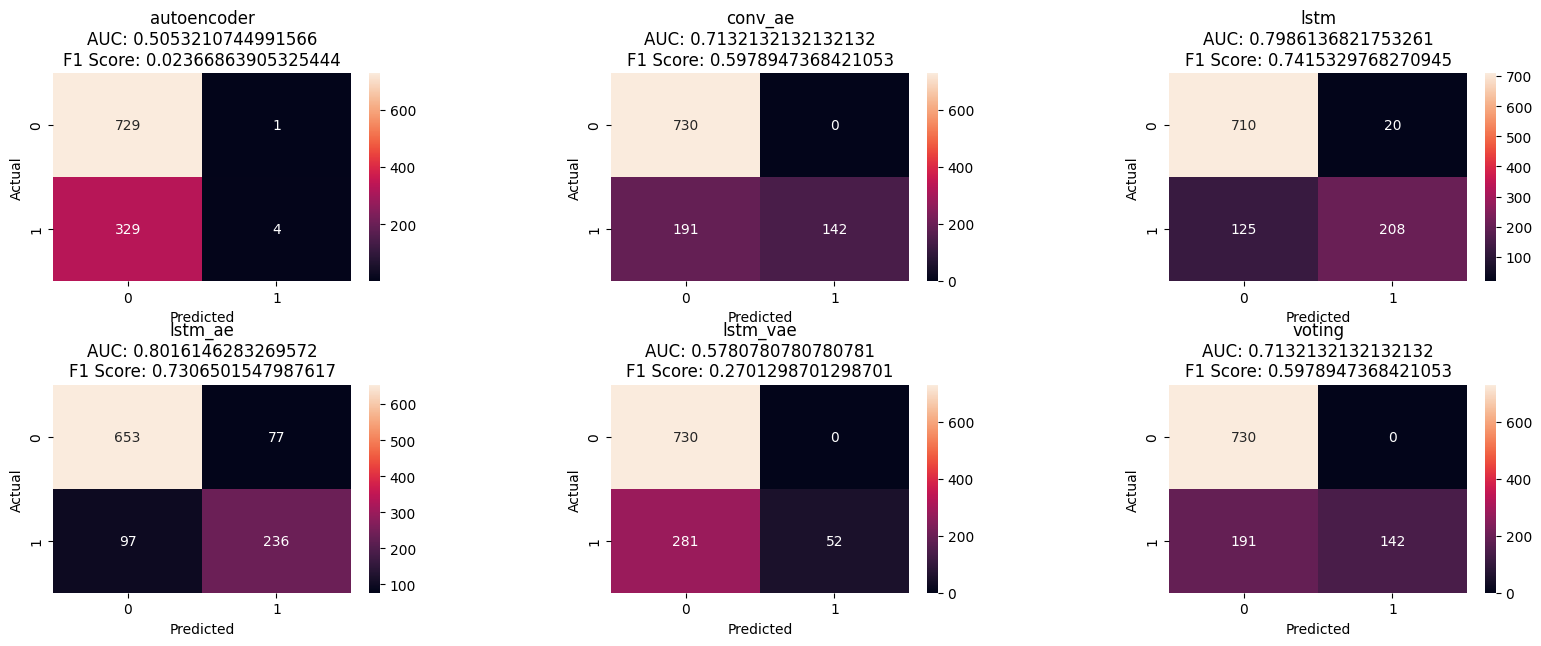
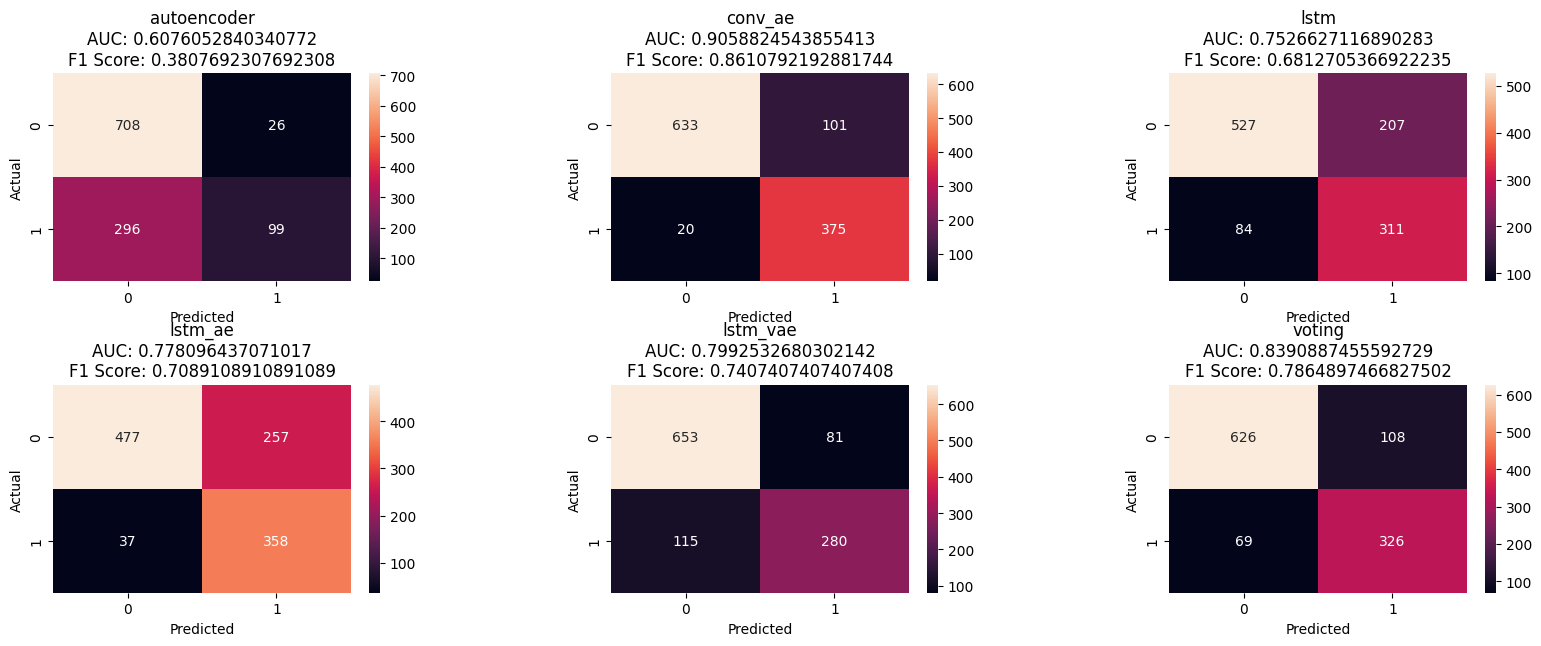
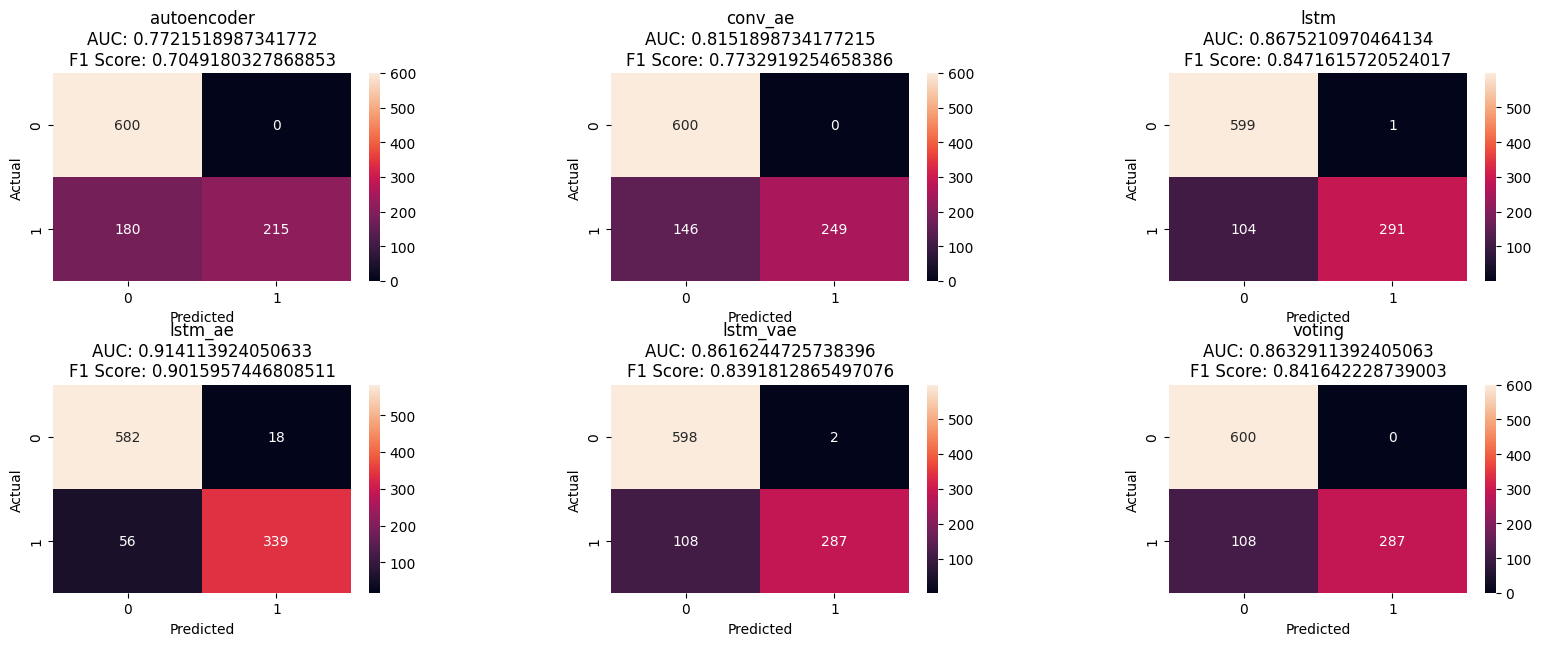

In [16]:
from IPython.display import HTML
import displayInfo
import pandas as pd

pd.set_option('display.max_colwidth', -1)
filename=[]
for i in range(0,34):
    filename.append(f"./images/{i}.png")

df = pd.DataFrame(data=filename, columns=["filename"])
df['image'] = df.filename.map(lambda f: displayInfo.get_thumbnail(f))

for i in range(0,12):
    df[f'image_A_{i}'] = "jasdjhasjdhjashdjhasd"

# display(df)
HTML(df[['filename', 'image', 'image_A_1','image_A_2','image_A_3','image_A_4']].to_html(formatters={'image': displayInfo.image_formatter}, escape=False))